#  GraphCast——AI预测天气：教学实验

**基于 Google DeepMind 论文：Learning skillful medium-range global weather forecasting (Science, 2023)**

---

## 课程简介

本实验将带你体验如何使用 AI（GraphCast 模型）进行全球天气预测。你将学习：

1. **天气数据**的基本结构与探索方法
2. **图神经网络 (GNN)** 在气象预测中的应用原理
3. **GraphCast** 模型的加载与推理
4. **可视化预测结果**（全球与中国区域）
5. **参数实验**与误差分析

---

## GraphCast 简介

| 特性 | 说明 |
|------|------|
| 开发者 | Google DeepMind |
| 发表 | Science, 2023 |
| 分辨率 | 0.25°（约28km）|
| 预测范围 | 10天 |
| 推理速度 | <1分钟（单次10天预测）|
| 核心技术 | 图神经网络（GNN）|

GraphCast 在超过 90% 的评估指标上超越了传统数值天气预报（NWP）系统 HRES。

---

##  目录

- 第零部分: 环境配置
- 第一部分: 天气数据探索
- 第二部分: 图神经网络与GraphCast原理
- 第三部分: 模型加载与预测
- 第四部分: 预测结果可视化与分析
- 第五部分: 参数实验
- 第六部分: 总结与拓展
- 附录

---
<a id='第零部分'></a>
# 第零部分: 环境配置

本部分将完成所有必要的环境配置，包括：
- GPU/TPU 检测
- GraphCast 包安装
- 预训练模型下载
- 样例数据下载

In [ ]:
#@title ## 0.1 检查运行环境
#@markdown **重要**：请确保已切换到 GPU 运行时！
#@markdown
#@markdown 推荐配置：
#@markdown - GPU: A100 / V100 / T4
#@markdown - 显存: ≥16GB（推荐40GB+）

import sys
import os

print("=" * 60)
print(" 环境检测")
print("=" * 60)

# Python 版本
print(f"\n Python 版本: {sys.version.split()[0]}")

# 检测是否在 Colab 环境
IN_COLAB = 'google.colab' in sys.modules
print(f" 运行环境: {'Google Colab' if IN_COLAB else '本地环境'}")

# GPU 检测
try:
    import subprocess
    result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'],
                          capture_output=True, text=True)
    if result.returncode == 0:
        gpu_info = result.stdout.strip()
        print(f"\n GPU 可用: {gpu_info}")
    else:
        print("\n 未检测到 GPU！")
except:
    print("\n 无法检测 GPU")

# TPU 检测
try:
    import jax
    devices = jax.devices()
    device_types = set([d.platform for d in devices])
    print(f"JAX 设备: {device_types}")
except:
    print("JAX 尚未安装")

print("\n" + "=" * 60)

 环境检测

 Python 版本: 3.12.12
 运行环境: Google Colab

 GPU 可用: NVIDIA A100-SXM4-40GB, 40960 MiB
JAX 设备: {'gpu'}



In [ ]:
#@title ## 0.2 安装依赖
#@markdown 安装 GraphCast 及相关依赖包
#@markdown

print(" 正在安装依赖...")
print("-" * 40)

# 安装 GraphCast
print("\n[1/4] 安装 GraphCast...")
!pip install --upgrade https://github.com/deepmind/graphcast/archive/master.zip -q

# 安装 cartopy（地图可视化）
print("[2/4] 安装 cartopy...")
!pip uninstall -y shapely -q
!pip install shapely --no-binary shapely -q
!pip install cartopy -q

# 安装其他依赖
print("[3/4] 安装其他依赖...")
!pip install xarray netcdf4 scipy matplotlib plotly ipywidgets -q

# 安装 gcsfs（访问 Google Cloud Storage）
print("[4/4] 安装 gcsfs...")
!pip install gcsfs -q

print("\n" + "-" * 40)
print(" 依赖安装完成！")

 正在安装依赖...
----------------------------------------

[1/4] 安装 GraphCast...
     / 1.7 MB 1.2 MB/s 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.3/374.3 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 740.4/740.4 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 126.2 MB/s eta 0:00:00
[2/4] 安装 cartopy...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 28.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (p

In [ ]:
#@title ## 0.3 导入库
#@markdown 导入所需的 Python 库

import dataclasses
import datetime
import functools
import math
import os
import pickle
from typing import Optional
import warnings

# 忽略警告
warnings.filterwarnings('ignore')

# 科学计算
import numpy as np
import xarray as xr
from scipy import stats

# 可视化
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import HTML, display

# GraphCast
from graphcast import autoregressive
from graphcast import casting
from graphcast import checkpoint
from graphcast import data_utils
from graphcast import graphcast
from graphcast import normalization
from graphcast import rollout
from graphcast import xarray_jax
from graphcast import xarray_tree

# JAX
import haiku as hk
import jax
import jax.numpy as jnp

# 配置 matplotlib
plt.rcParams['font.family'] = ['DejaVu Sans', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

# 创建输出目录
OUTPUT_DIR = '/content/outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(" 所有库导入成功！")
print(f" 输出目录: {OUTPUT_DIR}")
print(f"\n JAX 版本: {jax.__version__}")
print(f" JAX 设备: {jax.devices()}")

 所有库导入成功！
 输出目录: /content/outputs

 JAX 版本: 0.7.2
 JAX 设备: [CudaDevice(id=0)]


In [ ]:
#@title ## 0.4 下载预训练模型
#@markdown 从 Google Cloud Storage 下载 GraphCast 预训练模型
#@markdown
#@markdown | 模型 | 分辨率 | 气压层 | 大小 |
#@markdown |------|--------|--------|------|
#@markdown | GraphCast_small | 1° | 13层 | ~1GB |
#@markdown | GraphCast_operational | 0.25° | 13层 | ~4GB |
#@markdown

import gcsfs

# Google Cloud Storage 路径
GCS_BUCKET = "dm_graphcast"
GCS_PATH = f"gs://{GCS_BUCKET}/graphcast"

# 初始化 GCS 文件系统
gcs = gcsfs.GCSFileSystem(token='anon')

print(" 正在获取可用模型列表...")
print("-" * 50)

# 列出可用模型
try:
    params_files = gcs.ls(f"{GCS_BUCKET}/graphcast/params")
    params_files = [f for f in params_files if f.endswith('.npz')]

    print("\n可用模型:")
    for i, f in enumerate(params_files):
        name = os.path.basename(f)
        print(f"  [{i+1}] {name}")
except Exception as e:
    print(f" 获取模型列表失败: {e}")

print("\n" + "-" * 50)
print(" 模型列表获取成功！")

 正在获取可用模型列表...
--------------------------------------------------

可用模型:
  [1] GraphCast - ERA5 1979-2017 - resolution 0.25 - pressure levels 37 - mesh 2to6 - precipitation input and output.npz
  [2] GraphCast_operational - ERA5-HRES 1979-2021 - resolution 0.25 - pressure levels 13 - mesh 2to6 - precipitation output only.npz
  [3] GraphCast_small - ERA5 1979-2015 - resolution 1.0 - pressure levels 13 - mesh 2to5 - precipitation input and output.npz

--------------------------------------------------
 模型列表获取成功！


In [ ]:
#@title ## 0.5 选择并加载模型
#@markdown 选择要使用的模型版本
#@markdown
#@markdown ---
#@markdown ### 模型说明
#@markdown
#@markdown | 参数 | 说明 |
#@markdown |------|------|
#@markdown | `GraphCast_small` | 低分辨率版本，适合教学演示，运行快速 |
#@markdown | `GraphCast_operational` | 高分辨率版本，适合实际预测，需要更多显存 |

#@markdown ---

model_name = "GraphCast_small - ERA5 1979-2015 - resolution 1.0 - pressure levels 13 - mesh 2to5 - precipitation input and output.npz" #@param ["GraphCast_small - ERA5 1979-2015 - resolution 1.0 - pressure levels 13 - mesh 2to5 - precipitation input and output.npz", "GraphCast_operational - ERA5-HRES 1979-2021 - resolution 0.25 - pressure levels 13 - mesh 2to6 - precipitation output only.npz"] {allow-input: true}

print(" 正在下载模型...")
print(f"   模型: {model_name.split(' - ')[0]}")
print("-" * 50)

# 下载模型参数
params_path = f"{GCS_BUCKET}/graphcast/params/{model_name}"

with gcs.open(params_path, 'rb') as f:
    ckpt = checkpoint.load(f, graphcast.CheckPoint)
    params = ckpt.params
    state = {}

    model_config = ckpt.model_config
    task_config = ckpt.task_config

print("\n 模型加载成功！")
print("\n 模型配置:")
print(f"   分辨率: {model_config.resolution}°")
print(f"   网格层级: {model_config.mesh_size}")
print(f"   隐藏层维度: {model_config.latent_size}")
print(f"   GNN 层数: {model_config.gnn_msg_steps}")
print("\n 任务配置:")
print(f"   气压层: {task_config.pressure_levels}")
print(f"   输入变量数: {len(task_config.input_variables)}")
print(f"   目标变量数: {len(task_config.target_variables)}")

 正在下载模型...
   模型: GraphCast_small
--------------------------------------------------

 模型加载成功！

 模型配置:
   分辨率: 1.0°
   网格层级: 5
   隐藏层维度: 512
   GNN 层数: 16

 任务配置:
   气压层: (50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000)
   输入变量数: 18
   目标变量数: 11


In [ ]:
#@title ## 0.6 下载样例数据
#@markdown 下载 ERA5 样例数据集（用于输入和验证）
#@markdown

import pandas as pd

print(" 正在下载样例数据...")
print("-" * 50)

# 根据模型分辨率选择数据
resolution = model_config.resolution

if resolution == 1.0:
    dataset_file = "source-era5_date-2022-01-01_res-1.0_levels-13_steps-01.nc"
elif resolution == 0.25:
    dataset_file = "source-era5_date-2022-01-01_res-0.25_levels-13_steps-01.nc"
else:
    dataset_file = "source-era5_date-2022-01-01_res-1.0_levels-13_steps-01.nc"

# 下载数据
data_path = f"{GCS_BUCKET}/graphcast/dataset/{dataset_file}"

try:
    with gcs.open(data_path, 'rb') as f:
        example_batch = xr.load_dataset(f).compute()

    print(f"\n 数据下载成功！")
    print(f"   文件: {dataset_file}")
    print(f"   空间分辨率: {resolution}°")

    # 从 datetime 坐标获取实际时间（供后续可视化使用）
    datetime_val = example_batch.coords['datetime'].values[0, 0]
    TIME_STR = pd.Timestamp(datetime_val).strftime('%Y-%m-%d %H:%M UTC')
    print(f"   数据时间: {TIME_STR}")

    # 显示时间步信息
    n_times = example_batch.coords['datetime'].shape[1]
    print(f"   时间步数: {n_times}")

except Exception as e:
    print(f" 主数据下载失败: {e}")
    print("尝试备用数据...")

    # 列出可用数据文件
    data_files = gcs.ls(f"{GCS_BUCKET}/graphcast/dataset")
    nc_files = [f for f in data_files if f.endswith('.nc') and f'res-{resolution}' in f]

    if nc_files:
        with gcs.open(nc_files[0], 'rb') as f:
            example_batch = xr.load_dataset(f).compute()

        dataset_file = os.path.basename(nc_files[0])
        datetime_val = example_batch.coords['datetime'].values[0, 0]
        TIME_STR = pd.Timestamp(datetime_val).strftime('%Y-%m-%d %H:%M UTC')

        print(f"\n 备用数据下载成功！")
        print(f"   文件: {dataset_file}")
        print(f"   数据时间: {TIME_STR}")
    else:
        print(" 未找到可用数据文件")

print("\n" + "-" * 50)

 正在下载样例数据...
--------------------------------------------------

 数据下载成功！
   文件: source-era5_date-2022-01-01_res-1.0_levels-13_steps-01.nc
   空间分辨率: 1.0°
   数据时间: 2022-01-01 00:00 UTC
   时间步数: 3

--------------------------------------------------


In [ ]:
#@title ## 0.7 下载归一化统计量
#@markdown 下载用于数据标准化的统计量

print(" 正在下载归一化统计量...")
print("-" * 50)

# 下载统计量文件
stats_files = {
    'diffs_stddev': 'stats/diffs_stddev_by_level.nc',
    'mean': 'stats/mean_by_level.nc',
    'stddev': 'stats/stddev_by_level.nc'
}

stats_data = {}
for name, path in stats_files.items():
    full_path = f"{GCS_BUCKET}/graphcast/{path}"
    with gcs.open(full_path, 'rb') as f:
        stats_data[name] = xr.load_dataset(f).compute()
    print(f"   ✓ {name}")

diffs_stddev_by_level = stats_data['diffs_stddev']
mean_by_level = stats_data['mean']
stddev_by_level = stats_data['stddev']

print("\n" + "-" * 50)
print(" 归一化统计量下载完成！")

 正在下载归一化统计量...
--------------------------------------------------
   ✓ diffs_stddev
   ✓ mean
   ✓ stddev

--------------------------------------------------
 归一化统计量下载完成！


In [ ]:
#@title ## 0.8 环境验证
#@markdown 验证所有组件是否正确加载

print("=" * 60)
print(" 环境验证")
print("=" * 60)

# 检查模型
print("\n 模型状态:")
try:
    print(f"    模型参数已加载")
    print(f"    模型配置: 分辨率 {model_config.resolution}°, {len(task_config.pressure_levels)} 气压层")
except:
    print(f"    模型未加载")

# 检查数据
print("\n 数据状态:")
try:
    print(f"   样例数据已加载")
    print(f"   时间步数: {len(example_batch.time)}")
    print(f"   变量数: {len(example_batch.data_vars)}")
except:
    print(f"    数据未加载")

# 检查统计量
print("\n 统计量状态:")
try:
    print(f"   均值统计量已加载")
    print(f"   标准差统计量已加载")
except:
    print(f"    统计量未加载")

# 检查 JAX 设备
print("\n 计算设备:")
devices = jax.devices()
for d in devices:
    print(f"    {d}")

print("\n" + "=" * 60)
print(" 环境配置完成！可以开始实验了！")
print("=" * 60)

 环境验证

 模型状态:
    模型参数已加载
    模型配置: 分辨率 1.0°, 13 气压层

 数据状态:
   样例数据已加载
   时间步数: 3
   变量数: 14

 统计量状态:
   均值统计量已加载
   标准差统计量已加载

 计算设备:
    cuda:0

 环境配置完成！可以开始实验了！


---
<a id='第一部分'></a>
# 第一部分: 天气数据探索

在运行模型之前，我们先探索天气数据的结构，理解输入输出的含义。

## 1.1 天气变量介绍

| 变量类型 | 变量名 | 单位 | 说明 |
|----------|--------|------|------|
| 地表变量 | 2m_temperature | K | 地面2米高度温度 |
| 地表变量 | 10m_u_component_of_wind | m/s | 10米高度纬向风 |
| 地表变量 | 10m_v_component_of_wind | m/s | 10米高度经向风 |
| 地表变量 | mean_sea_level_pressure | Pa | 海平面气压 |
| 大气变量 | temperature | K | 各气压层温度 |
| 大气变量 | geopotential | m²/s² | 位势高度 |
| 大气变量 | specific_humidity | kg/kg | 比湿 |
| 大气变量 | u_component_of_wind | m/s | 纬向风 |
| 大气变量 | v_component_of_wind | m/s | 经向风 |

In [ ]:
#@title ## 1.2 探索数据结构
#@markdown 查看数据集的维度和变量

print("=" * 60)
print(" 数据集概览")
print("=" * 60)

# 基本信息
print(f"\n 维度信息:")
for dim, size in example_batch.dims.items():
    print(f"   {dim}: {size}")

# 坐标信息
print(f"\n 坐标范围:")
print(f"   经度 (lon): {float(example_batch.lon.min()):.2f}° ~ {float(example_batch.lon.max()):.2f}°")
print(f"   纬度 (lat): {float(example_batch.lat.min()):.2f}° ~ {float(example_batch.lat.max()):.2f}°")
print(f"   时间 (time): {example_batch.time.values}")

# 气压层
if 'level' in example_batch.dims:
    print(f"\n 气压层 (hPa):")
    levels = example_batch.level.values
    print(f"   {levels}")

# 变量列表
print(f"\n 变量列表 ({len(example_batch.data_vars)} 个):")
for var in sorted(example_batch.data_vars):
    shape = example_batch[var].shape
    print(f"   • {var}: {shape}")

print("\n" + "=" * 60)

 数据集概览

 维度信息:
   lat: 181
   lon: 360
   batch: 1
   time: 3
   level: 13

 坐标范围:
   经度 (lon): 0.00° ~ 359.00°
   纬度 (lat): -90.00° ~ 90.00°
   时间 (time): [             0 21600000000000 43200000000000]

 气压层 (hPa):
   [  50  100  150  200  250  300  400  500  600  700  850  925 1000]

 变量列表 (14 个):
   • 10m_u_component_of_wind: (1, 3, 181, 360)
   • 10m_v_component_of_wind: (1, 3, 181, 360)
   • 2m_temperature: (1, 3, 181, 360)
   • geopotential: (1, 3, 13, 181, 360)
   • geopotential_at_surface: (181, 360)
   • land_sea_mask: (181, 360)
   • mean_sea_level_pressure: (1, 3, 181, 360)
   • specific_humidity: (1, 3, 13, 181, 360)
   • temperature: (1, 3, 13, 181, 360)
   • toa_incident_solar_radiation: (1, 3, 181, 360)
   • total_precipitation_6hr: (1, 3, 181, 360)
   • u_component_of_wind: (1, 3, 13, 181, 360)
   • v_component_of_wind: (1, 3, 13, 181, 360)
   • vertical_velocity: (1, 3, 13, 181, 360)



 图片已保存: /content/outputs/global_temperature.png


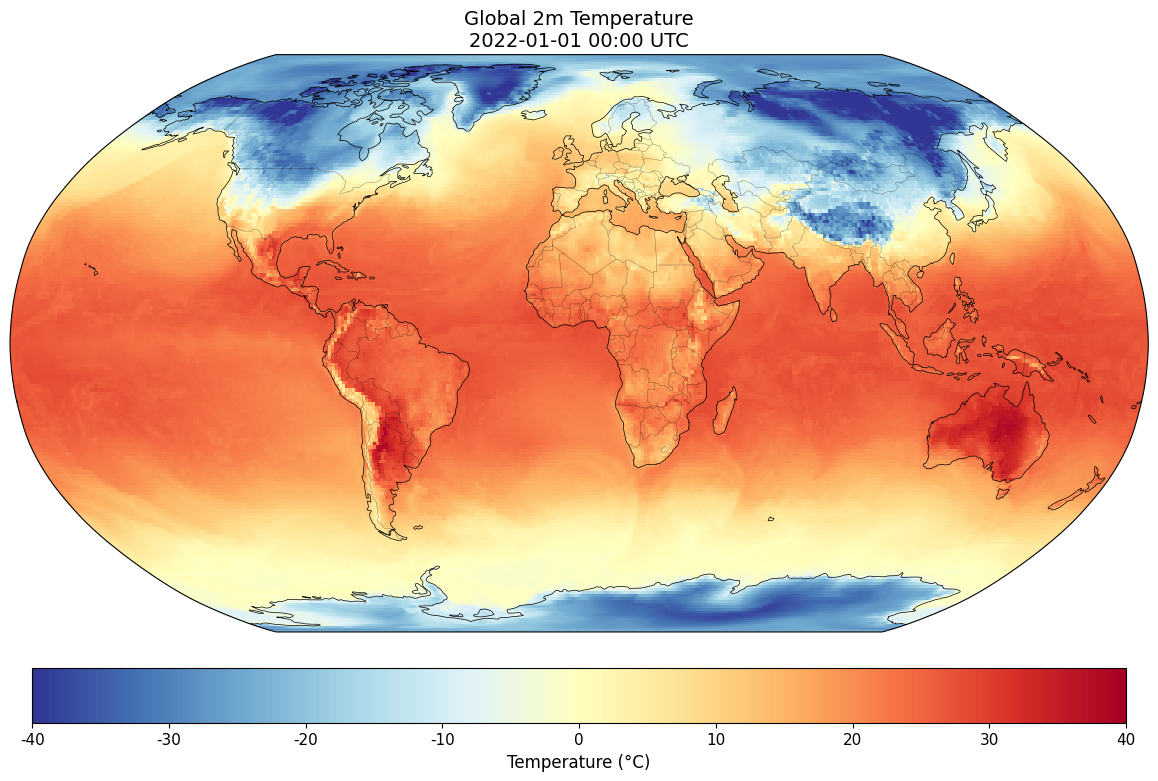

In [ ]:
#@title ## 1.3 可视化全球温度场
#@markdown 绘制全球地表温度分布图

# 提取地表温度
temp_var = '2m_temperature'
if temp_var in example_batch.data_vars:
    temp_data = example_batch[temp_var].isel(time=0, batch=0)
else:
    # 尝试其他可能的变量名
    for var in example_batch.data_vars:
        if 'temperature' in var.lower() and '2m' in var.lower():
            temp_data = example_batch[var].isel(time=0, batch=0)
            temp_var = var
            break

# 转换为摄氏度
temp_celsius = temp_data - 273.15

# 创建图形
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# 绘制温度场
im = ax.pcolormesh(
    example_batch.lon, example_batch.lat, temp_celsius,
    transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r',
    vmin=-40, vmax=40
)

# 添加地理特征
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.5)

# 添加颜色条
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('Temperature (°C)', fontsize=12)

# 标题
ax.set_title(f'Global 2m Temperature\n{TIME_STR}', fontsize=14)

plt.tight_layout()

# 保存图片
save_path = f"{OUTPUT_DIR}/global_temperature.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f" 图片已保存: {save_path}")

plt.show()

当前区域: 珠三角
  经度: 111E ~ 117E
  纬度: 21N ~ 25N
数据形状: (5, 7)
图片已保存: /content/outputs/china_temperature_珠三角.png


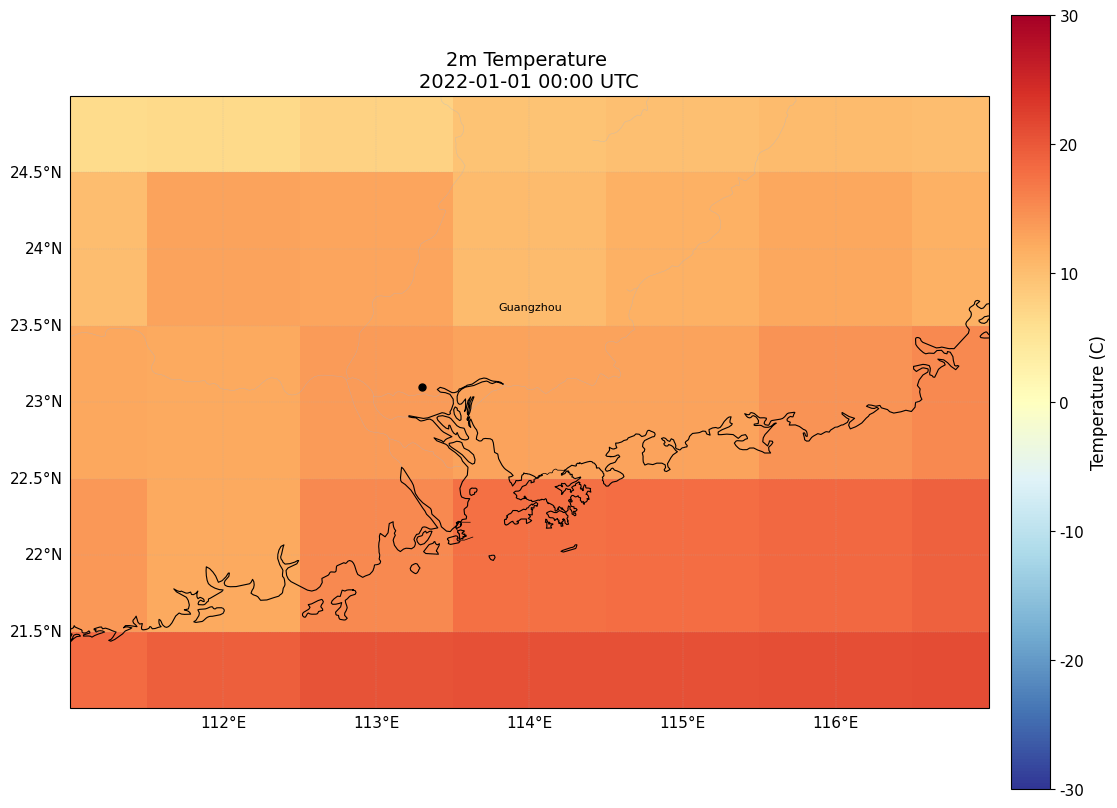

In [ ]:
#@title ## 1.4 中国区域温度分布
#@markdown 聚焦中国区域，查看温度分布细节
#@markdown
#@markdown ---
#@markdown ###  区域选择

region_preset = "华北地区" #@param ["全中国", "华北地区", "长三角", "珠三角", "西北地区", "东北地区", "自定义"]

#@markdown ---
#@markdown ###  自定义区域（仅当选择"自定义"时生效）

#@markdown | 参数 | 中文名 | 说明 |
#@markdown |------|--------|------|
#@markdown | `custom_lon_min` | 最小经度 | 区域西边界（°E）|
#@markdown | `custom_lon_max` | 最大经度 | 区域东边界（°E）|
#@markdown | `custom_lat_min` | 最小纬度 | 区域南边界（°N）|
#@markdown | `custom_lat_max` | 最大纬度 | 区域北边界（°N）|
#@markdown
#@markdown > 经度范围：东经 73° 至 135°，纬度范围：北纬 18° 至 54°

custom_lon_min = 73 #@param {type:"number"}
custom_lon_max = 135 #@param {type:"number"}
custom_lat_min = 18 #@param {type:"number"}
custom_lat_max = 54 #@param {type:"number"}

#@markdown ---
#@markdown ###  显示设置

#@markdown | 参数 | 中文名 | 说明 |
#@markdown |------|--------|------|
#@markdown | `temp_min` | 最低温度 | 色标下限（°C），低于此值显示为深蓝色 |
#@markdown | `temp_max` | 最高温度 | 色标上限（°C），高于此值显示为深红色 |
#@markdown | `show_cities` | 显示城市 | 勾选后在地图上标注主要城市位置 |
#@markdown | `show_rivers` | 显示河流 | 勾选后显示主要河流水系 |

temp_min = -30 #@param {type:"slider", min:-50, max:0, step:5}
temp_max = 30 #@param {type:"slider", min:0, max:50, step:5}

show_cities = True #@param {type:"boolean"}
show_rivers = True #@param {type:"boolean"}

# ============ 主要城市坐标 ============
cities = {
    'Beijing': (116.4, 39.9),
    'Shanghai': (121.5, 31.2),
    'Guangzhou': (113.3, 23.1),
    'Chengdu': (104.1, 30.7),
    'Haerbin': (126.6, 45.8),
    'Wulumuqi': (87.6, 43.8),
    'Xian': (108.9, 34.3),
    'Wuhan': (114.3, 30.6),
}

# ============ 预设区域定义 ============
region_bounds = {
    "全中国":   {"lon": (73, 135),  "lat": (18, 54)},
    "华北地区": {"lon": (110, 120), "lat": (34, 42)},
    "长三角":   {"lon": (118, 123), "lat": (29, 34)},
    "珠三角":   {"lon": (111, 117), "lat": (21, 25)},
    "西北地区": {"lon": (73, 110),  "lat": (32, 50)},
    "东北地区": {"lon": (118, 135), "lat": (38, 54)},
    "自定义":   {"lon": (custom_lon_min, custom_lon_max),
                "lat": (custom_lat_min, custom_lat_max)},
}

# 获取选定区域的边界
bounds = region_bounds[region_preset]
lon_min, lon_max = bounds["lon"]
lat_min, lat_max = bounds["lat"]

print(f"当前区域: {region_preset}")
print(f"  经度: {lon_min}E ~ {lon_max}E")
print(f"  纬度: {lat_min}N ~ {lat_max}N")

# ============ 裁剪数据 ============
# 先对纬度排序，确保切片方向正确
temp_sorted = temp_celsius.sortby('lat')
china_temp = temp_sorted.sel(
    lon=slice(lon_min, lon_max),
    lat=slice(lat_min, lat_max)
)

if china_temp.size == 0:
    print("[!] 裁剪后数据为空，请检查经纬度范围")
else:
    print(f"数据形状: {china_temp.shape}")

    # ============ 绑图 ============
    fig = plt.figure(figsize=(12, 10))

    # 使用 PlateCarree 投影 (横平竖直)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # 绘制温度场
    im = ax.pcolormesh(
        china_temp.lon, china_temp.lat, china_temp.values,
        transform=ccrs.PlateCarree(),
        cmap='RdYlBu_r',
        vmin=temp_min, vmax=temp_max,
        shading='auto'
    )

    # 添加地理特征
    ax.coastlines(linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    if show_rivers:
        ax.add_feature(cfeature.RIVERS, linewidth=0.3, alpha=0.5)

    # 添加网格线
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # 标注主要城市
    if show_cities:
        for city, (clon, clat) in cities.items():
            if lon_min <= clon <= lon_max and lat_min <= clat <= lat_max:
                ax.plot(clon, clat, 'ko', markersize=5, transform=ccrs.PlateCarree())
                ax.text(clon + 0.5, clat + 0.5, city, fontsize=8, transform=ccrs.PlateCarree())

    # 颜色条
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, shrink=0.8)
    cbar.set_label('Temperature (C)', fontsize=12)

    ax.set_title(f'2m Temperature \n{TIME_STR}', fontsize=14)

    plt.tight_layout()

    # 保存图片
    save_path = f"{OUTPUT_DIR}/china_temperature_{region_preset}.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"图片已保存: {save_path}")

    plt.show()

 裁剪后数据形状: (5, 7)
   经度范围: 111.0° ~ 117.0°
   纬度范围: 21.0° ~ 25.0°
 图片已保存: /content/outputs/china_wind_field.png


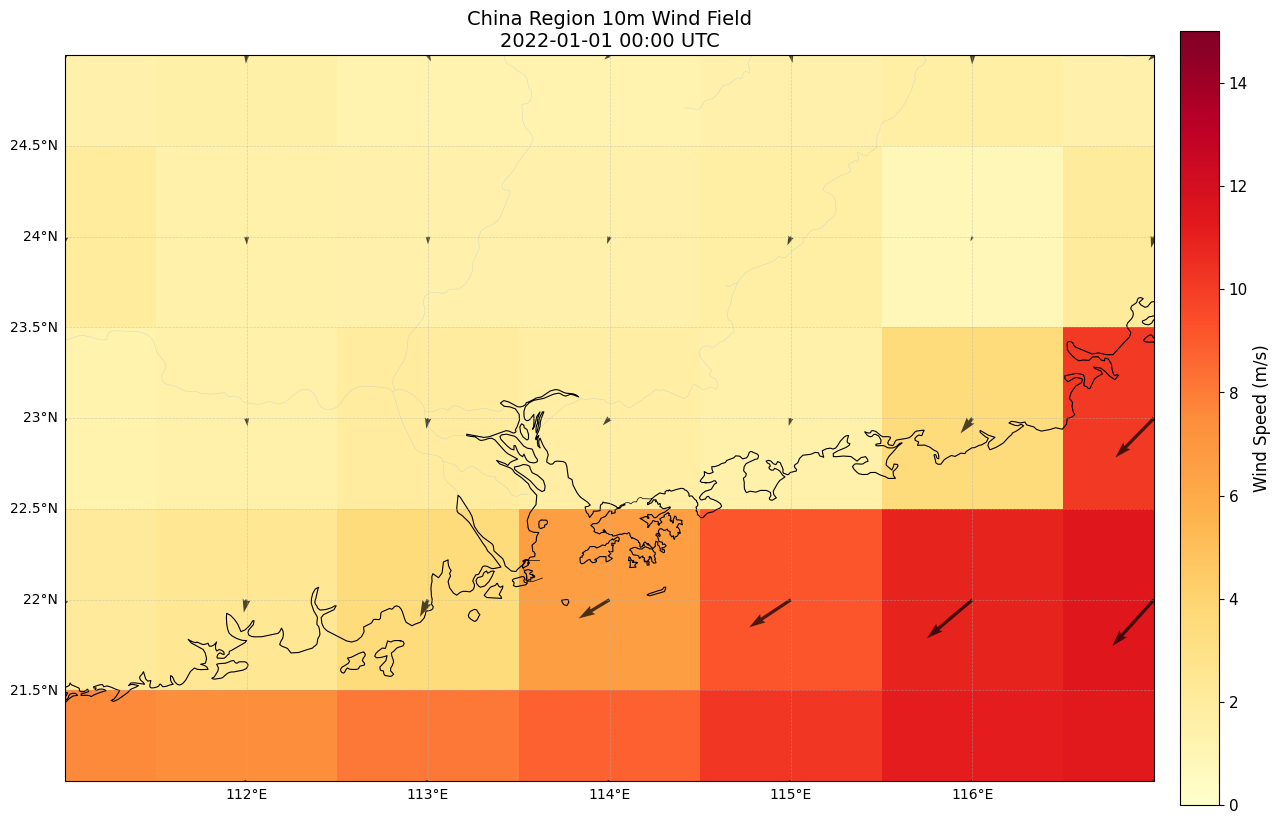

In [ ]:
#@title ## 1.5 风场可视化
#@markdown 绘制10米高度风场（矢量图）

# 提取风场数据
u_wind = example_batch['10m_u_component_of_wind'].isel(time=0, batch=0)
v_wind = example_batch['10m_v_component_of_wind'].isel(time=0, batch=0)

# 计算风速
wind_speed = np.sqrt(u_wind**2 + v_wind**2)

# 检查纬度排列顺序并正确裁剪
lat_ascending = float(u_wind.lat[0]) < float(u_wind.lat[-1])

if lat_ascending:
    # 纬度从小到大排列 (-90 → 90)
    lat_slice = slice(lat_min, lat_max)
else:
    # 纬度从大到小排列 (90 → -90)
    lat_slice = slice(lat_max, lat_min)

# 中国区域裁剪
u_china = u_wind.sel(lon=slice(lon_min, lon_max), lat=lat_slice)
v_china = v_wind.sel(lon=slice(lon_min, lon_max), lat=lat_slice)
ws_china = wind_speed.sel(lon=slice(lon_min, lon_max), lat=lat_slice)

# 检查数据是否为空
if u_china.size == 0 or ws_china.size == 0:
    print(" 裁剪后数据为空，尝试使用 .where() 方法...")
    # 备用方法：使用布尔掩码
    lon_mask = (u_wind.lon >= lon_min) & (u_wind.lon <= lon_max)
    lat_mask = (u_wind.lat >= lat_min) & (u_wind.lat <= lat_max)

    u_china = u_wind.where(lon_mask & lat_mask, drop=True)
    v_china = v_wind.where(lon_mask & lat_mask, drop=True)
    ws_china = wind_speed.where(lon_mask & lat_mask, drop=True)

print(f" 裁剪后数据形状: {ws_china.shape}")
print(f"   经度范围: {float(ws_china.lon.min()):.1f}° ~ {float(ws_china.lon.max()):.1f}°")
print(f"   纬度范围: {float(ws_china.lat.min()):.1f}° ~ {float(ws_china.lat.max()):.1f}°")

# 创建图形 - 使用 PlateCarree 投影（横平竖直）
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# 绘制风速底图
im = ax.pcolormesh(
    ws_china.lon, ws_china.lat, ws_china.values,
    transform=ccrs.PlateCarree(),
    cmap='YlOrRd',
    vmin=0, vmax=15,
    shading='auto'
)

# 绘制风矢量（间隔取样以避免太密集）
skip = max(1, len(u_china.lon) // 15)
lon_sub = u_china.lon.values[::skip]
lat_sub = u_china.lat.values[::skip]
u_sub = u_china.values[::skip, ::skip]
v_sub = v_china.values[::skip, ::skip]

# 创建网格用于 quiver
lon_grid, lat_grid = np.meshgrid(lon_sub, lat_sub)

ax.quiver(
    lon_grid, lat_grid, u_sub, v_sub,
    transform=ccrs.PlateCarree(),
    scale=200, width=0.003, color='black', alpha=0.7
)

# 地理特征
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.RIVERS, linewidth=0.3, alpha=0.5)

# 添加经纬度网格线和标签
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# 颜色条
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, shrink=0.8)
cbar.set_label('Wind Speed (m/s)', fontsize=12)

ax.set_title(f'China Region 10m Wind Field\n{TIME_STR}', fontsize=14)

plt.tight_layout()

# 保存图片
save_path = f"{OUTPUT_DIR}/china_wind_field.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f" 图片已保存: {save_path}")

plt.show()

数据维度: ('level', 'lat')
数据形状: (13, 181)
气压层数: 13, 纬度点数: 181
图片已保存: /content/outputs/vertical_temp_profile.png


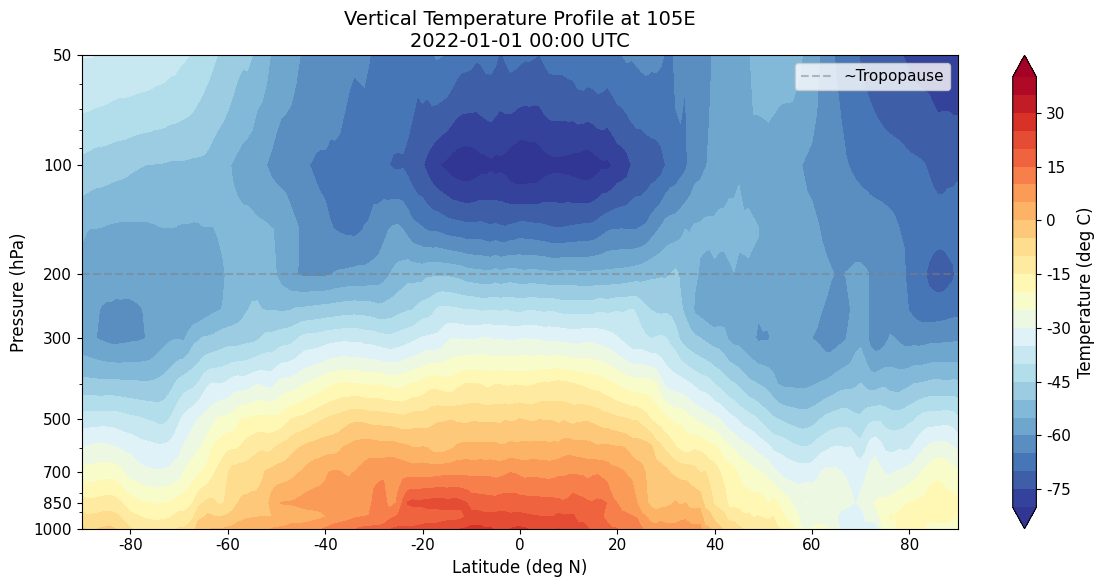

In [ ]:
#@title ## 1.6 垂直温度剖面
#@markdown 查看中国中部 105°E不同气压层的温度分布

# 检查是否有多层数据
if 'level' in example_batch.dims:
    # 选择一个经度剖面（中国中部 105°E）
    profile_lon = 105

    temp_profile = example_batch['temperature'].isel(time=0, batch=0).sel(
        lon=profile_lon, method='nearest'
    )
    temp_profile_c = temp_profile - 273.15

    # 获取坐标
    levels = temp_profile.level.values
    lats = temp_profile.lat.values

    # 检查数据维度顺序
    print(f"数据维度: {temp_profile_c.dims}")
    print(f"数据形状: {temp_profile_c.shape}")
    print(f"气压层数: {len(levels)}, 纬度点数: {len(lats)}")

    # 确保数据形状正确: contourf(X, Y, Z) 需要 Z.shape = (len(Y), len(X))
    # X = lats, Y = levels, 所以 Z.shape 应该是 (len(levels), len(lats))
    data = temp_profile_c.values

    # 根据实际维度顺序调整
    if temp_profile_c.dims == ('lat', 'level'):
        data = data.T  # 转置为 (level, lat)
    # 如果已经是 ('level', 'lat') 则不需要转置

    # 创建图形
    fig, ax = plt.subplots(figsize=(12, 6))

    # 绘制温度剖面
    im = ax.contourf(
        lats, levels, data,
        levels=np.arange(-80, 41, 5),
        cmap='RdYlBu_r',
        extend='both'
    )

    # 反转y轴（气压从下到上递减）
    ax.invert_yaxis()
    ax.set_yscale('log')

    # 设置y轴刻度
    ax.set_yticks([1000, 850, 700, 500, 300, 200, 100, 50])
    ax.set_yticklabels(['1000', '850', '700', '500', '300', '200', '100', '50'])

    # 标签
    ax.set_xlabel('Latitude (deg N)', fontsize=12)
    ax.set_ylabel('Pressure (hPa)', fontsize=12)
    ax.set_title(f'Vertical Temperature Profile at {profile_lon}E\n{TIME_STR}', fontsize=14)

    # 颜色条
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Temperature (deg C)', fontsize=12)

    # 标注对流层顶大致位置
    ax.axhline(y=200, color='gray', linestyle='--', alpha=0.5, label='~Tropopause')
    ax.legend(loc='upper right')

    plt.tight_layout()

    # 保存图片
    save_path = f"{OUTPUT_DIR}/vertical_temp_profile.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"图片已保存: {save_path}")

    plt.show()
else:
    print("数据中没有垂直层信息 (level 维度不存在)")

---
<a id='第二部分'></a>
# 第二部分: 图神经网络与GraphCast原理

## 2.1 为什么使用图神经网络？

传统天气预报使用**数值天气预报（NWP）**，需要求解复杂的偏微分方程。GraphCast 使用 **图神经网络（GNN）** 直接从历史数据中学习天气演变规律。

| 方法 | 原理 | 优点 | 缺点 |
|------|------|------|------|
| NWP | 求解物理方程 | 物理可解释 | 计算量大，耗时长 |
| GraphCast | 数据驱动学习 | 速度快，精度高 | 需要大量训练数据 |

## 2.2 GraphCast 的图结构

GraphCast 将地球表面建模为一个**多尺度图**：

1. **网格节点（Grid Nodes）**：对应经纬度网格点，包含天气变量
2. **网格边（Grid Edges）**：连接相邻网格点
3. **多分辨率网格（Multi-mesh）**：使用二十面体细分，实现多尺度信息传递

 图片已保存: /content/outputs/graphcast_mesh_structure.png


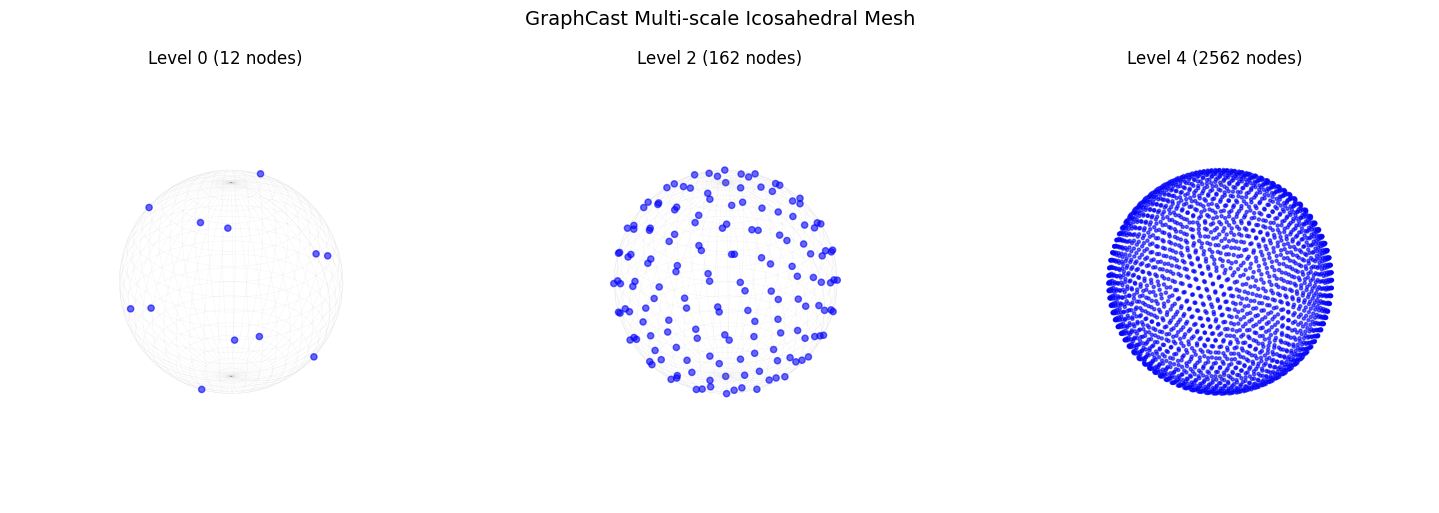

In [ ]:
#@title ## 2.3 可视化图结构
#@markdown 展示 GraphCast 的多尺度网格结构

from mpl_toolkits.mplot3d import Axes3D

def icosahedron_vertices():
    """生成正二十面体的顶点"""
    phi = (1 + np.sqrt(5)) / 2  # 黄金比例
    vertices = np.array([
        [-1, phi, 0], [1, phi, 0], [-1, -phi, 0], [1, -phi, 0],
        [0, -1, phi], [0, 1, phi], [0, -1, -phi], [0, 1, -phi],
        [phi, 0, -1], [phi, 0, 1], [-phi, 0, -1], [-phi, 0, 1]
    ])
    # 归一化到单位球面
    vertices = vertices / np.linalg.norm(vertices, axis=1, keepdims=True)
    return vertices

def subdivide_icosahedron(vertices, faces, n_subdivisions):
    """细分二十面体"""
    for _ in range(n_subdivisions):
        new_faces = []
        edge_midpoints = {}

        for face in faces:
            midpoints = []
            for i in range(3):
                edge = tuple(sorted([face[i], face[(i+1)%3]]))
                if edge not in edge_midpoints:
                    mid = (vertices[edge[0]] + vertices[edge[1]]) / 2
                    mid = mid / np.linalg.norm(mid)  # 投影到球面
                    edge_midpoints[edge] = len(vertices)
                    vertices = np.vstack([vertices, mid])
                midpoints.append(edge_midpoints[edge])

            # 创建4个新三角形
            new_faces.append([face[0], midpoints[0], midpoints[2]])
            new_faces.append([midpoints[0], face[1], midpoints[1]])
            new_faces.append([midpoints[2], midpoints[1], face[2]])
            new_faces.append([midpoints[0], midpoints[1], midpoints[2]])

        faces = new_faces

    return vertices, faces

# 初始二十面体面
initial_faces = [
    [0, 11, 5], [0, 5, 1], [0, 1, 7], [0, 7, 10], [0, 10, 11],
    [1, 5, 9], [5, 11, 4], [11, 10, 2], [10, 7, 6], [7, 1, 8],
    [3, 9, 4], [3, 4, 2], [3, 2, 6], [3, 6, 8], [3, 8, 9],
    [4, 9, 5], [2, 4, 11], [6, 2, 10], [8, 6, 7], [9, 8, 1]
]

# 创建不同细分级别的网格
fig = plt.figure(figsize=(15, 5))

subdivisions = [0, 2, 4]
titles = ['Level 0 (12 nodes)', 'Level 2 (162 nodes)', 'Level 4 (2562 nodes)']

for idx, (n_sub, title) in enumerate(zip(subdivisions, titles)):
    ax = fig.add_subplot(1, 3, idx+1, projection='3d')

    vertices = icosahedron_vertices()
    if n_sub > 0:
        vertices, _ = subdivide_icosahedron(vertices.copy(), initial_faces.copy(), n_sub)

    # 绘制节点
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2],
               c='blue', s=20 if n_sub < 3 else 5, alpha=0.6)

    # 绘制球面轮廓
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 25)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.1, linewidth=0.3)

    ax.set_title(title, fontsize=12)
    ax.set_box_aspect([1,1,1])
    ax.axis('off')

plt.suptitle('GraphCast Multi-scale Icosahedral Mesh', fontsize=14, y=1.02)
plt.tight_layout()

# 保存图片
save_path = f"{OUTPUT_DIR}/graphcast_mesh_structure.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f" 图片已保存: {save_path}")

plt.show()

 GraphCast 架构解析

GraphCast 采用 Encoder-Processor-Decoder 架构:

1. Input (输入层)
   - 接收连续2个时间步的ERA5气象数据
   - 包含地表变量和多层大气变量

2. Encoder (编码器)
   - Grid -> Mesh: 将经纬度网格映射到二十面体网格
   - 使用 MLP 进行特征嵌入

3. Processor (处理器)
   - 核心组件: 16层图神经网络 (GNN)
   - 在多尺度网格上进行消息传递
   - 捕捉不同空间尺度的天气模式

4. Decoder (解码器)
   - Mesh -> Grid: 将网格特征映射回经纬度网格
   - 使用 MLP 进行特征投影

5. Output (输出层)
   - 预测变化量 Delta (残差学习)
   - 最终预测 = 当前状态 + Delta


[Figure saved: /content/outputs/graphcast_architecture.png]


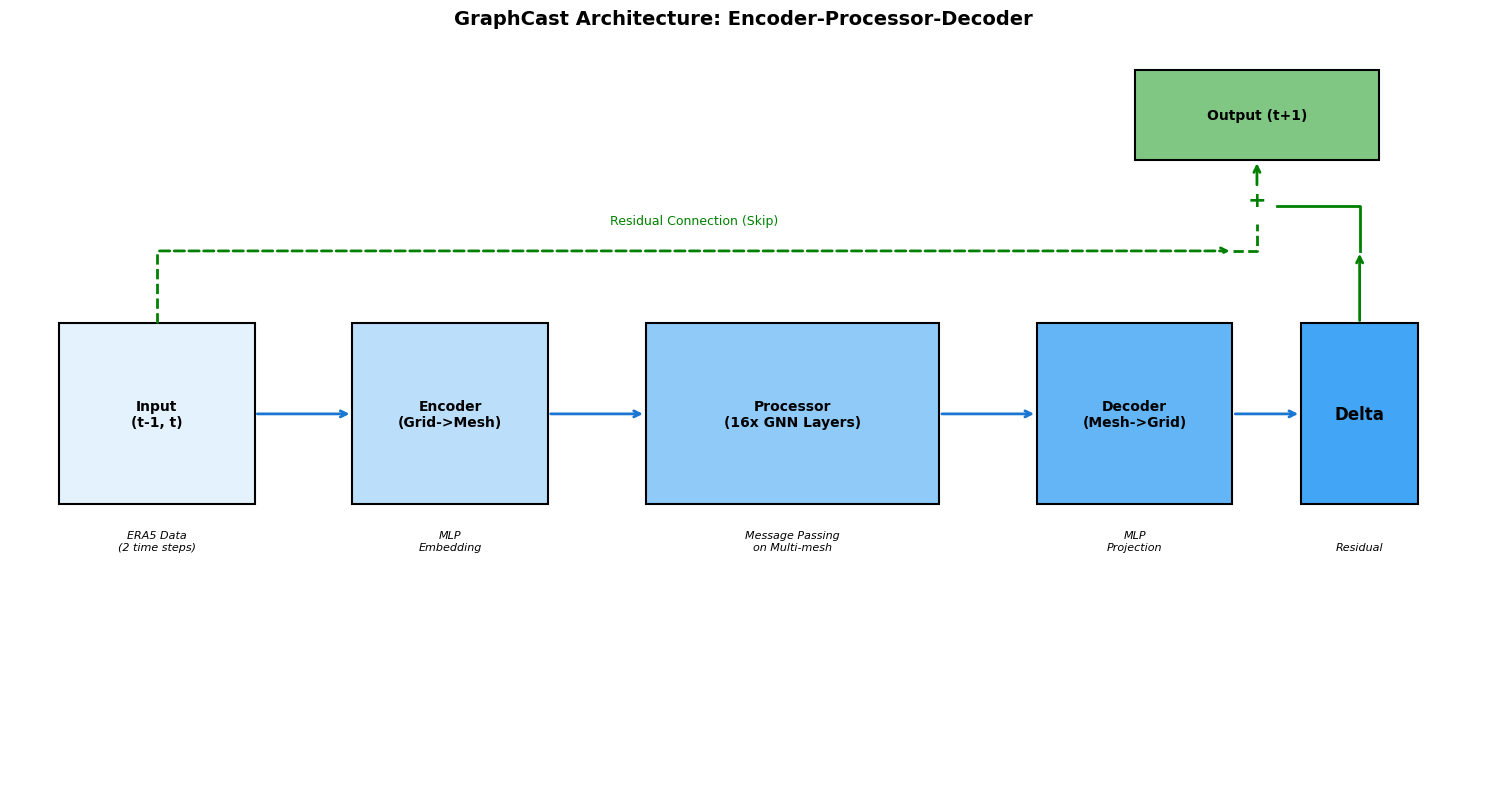


--- 关键设计思想 ---

* 残差学习: 预测 Delta 而非绝对值，降低学习难度
* 多尺度网格: 不同分辨率捕捉局部和全局天气模式
* 自回归预测: 将 t+1 的输出作为下一步输入，迭代预测多步



In [ ]:
#@title ## 2.4 GraphCast 架构图解
#@markdown 展示 Encoder-Processor-Decoder 架构
#@markdown
#@markdown ---
#@markdown ### 架构说明
#@markdown
#@markdown | 模块 | 功能 |
#@markdown |------|------|
#@markdown | **Input** | 输入连续2个时间步的气象数据 (t-1, t) |
#@markdown | **Encoder** | 将规则网格数据编码到多尺度二十面体网格 |
#@markdown | **Processor** | 16层图神经网络，在网格上进行消息传递 |
#@markdown | **Decoder** | 将网格特征解码回原始经纬度网格 |
#@markdown | **Output** | 输出变化量 Delta，与输入相加得到预测结果 |
#@markdown
#@markdown ---

print("=" * 60)
print(" GraphCast 架构解析")
print("=" * 60)
print("""
GraphCast 采用 Encoder-Processor-Decoder 架构:

1. Input (输入层)
   - 接收连续2个时间步的ERA5气象数据
   - 包含地表变量和多层大气变量

2. Encoder (编码器)
   - Grid -> Mesh: 将经纬度网格映射到二十面体网格
   - 使用 MLP 进行特征嵌入

3. Processor (处理器)
   - 核心组件: 16层图神经网络 (GNN)
   - 在多尺度网格上进行消息传递
   - 捕捉不同空间尺度的天气模式

4. Decoder (解码器)
   - Mesh -> Grid: 将网格特征映射回经纬度网格
   - 使用 MLP 进行特征投影

5. Output (输出层)
   - 预测变化量 Delta (残差学习)
   - 最终预测 = 当前状态 + Delta
""")
print("=" * 60)

# 绘制架构图
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_xlim(0, 15)  # 扩大画布范围
ax.set_ylim(0, 8)
ax.axis('off')

# 颜色定义
colors = {
    'input': '#E3F2FD',
    'encoder': '#BBDEFB',
    'processor': '#90CAF9',
    'decoder': '#64B5F6',
    'output': '#42A5F5',
    'arrow': '#1976D2'
}

# 绘制模块
def draw_box(ax, x, y, w, h, text, color, fontsize=10):
    rect = plt.Rectangle((x, y), w, h, facecolor=color, edgecolor='black', linewidth=1.5)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=fontsize, fontweight='bold')

def draw_arrow(ax, x1, y1, x2, y2, color='black'):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', color=color, lw=2))

# 输入
draw_box(ax, 0.5, 3, 2, 2, 'Input\n(t-1, t)', colors['input'])
ax.text(1.5, 2.5, 'ERA5 Data\n(2 time steps)', ha='center', fontsize=8, style='italic')

# Encoder
draw_box(ax, 3.5, 3, 2, 2, 'Encoder\n(Grid->Mesh)', colors['encoder'])
ax.text(4.5, 2.5, 'MLP\nEmbedding', ha='center', fontsize=8, style='italic')

# Processor (GNN)
draw_box(ax, 6.5, 3, 3, 2, 'Processor\n(16x GNN Layers)', colors['processor'])
ax.text(8, 2.5, 'Message Passing\non Multi-mesh', ha='center', fontsize=8, style='italic')

# Decoder
draw_box(ax, 10.5, 3, 2, 2, 'Decoder\n(Mesh->Grid)', colors['decoder'])
ax.text(11.5, 2.5, 'MLP\nProjection', ha='center', fontsize=8, style='italic')

# Delta 输出
draw_box(ax, 13.2, 3, 1.2, 2, 'Delta', colors['output'], fontsize=12)
ax.text(13.8, 2.5, 'Residual', ha='center', fontsize=8, style='italic')

# 箭头
draw_arrow(ax, 2.5, 4, 3.5, 4, colors['arrow'])
draw_arrow(ax, 5.5, 4, 6.5, 4, colors['arrow'])
draw_arrow(ax, 9.5, 4, 10.5, 4, colors['arrow'])
draw_arrow(ax, 12.5, 4, 13.2, 4, colors['arrow'])

# 残差连接 (从 Input 到加号)
# 从 Input 框顶部引出垂直线
ax.plot([1.5, 1.5], [5, 5.8], color='green', lw=2, ls='--')
# 水平虚线箭头
ax.annotate('', xy=(12.5, 5.8), xytext=(1.5, 5.8),
            arrowprops=dict(arrowstyle='->', color='green', lw=2, ls='--'))
ax.text(7, 6.1, 'Residual Connection (Skip)', ha='center', fontsize=9, color='green')

# 最终输出框
draw_box(ax, 11.5, 6.8, 2.5, 1, 'Output (t+1)', '#81C784')

# 加号位置和箭头
ax.text(12.75, 6.3, '+', fontsize=16, ha='center', fontweight='bold', color='green')

# 从 Delta 到加号
ax.annotate('', xy=(13.8, 5.8), xytext=(13.8, 5),
            arrowprops=dict(arrowstyle='->', color='green', lw=2))

# 从加号到 Output
ax.annotate('', xy=(12.75, 6.8), xytext=(12.75, 6.5),
            arrowprops=dict(arrowstyle='->', color='green', lw=2))

# 残差连接弯折到加号
ax.plot([12.5, 12.75, 12.75], [5.8, 5.8, 6.1], color='green', lw=2, ls='--')
ax.plot([13.8, 13.8, 12.95], [5.8, 6.3, 6.3], color='green', lw=2)

# 标题
ax.set_title('GraphCast Architecture: Encoder-Processor-Decoder', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()

# 保存图片
save_path = f"{OUTPUT_DIR}/graphcast_architecture.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"\n[Figure saved: {save_path}]")

plt.show()

# 补充说明
print("""
--- 关键设计思想 ---

* 残差学习: 预测 Delta 而非绝对值，降低学习难度
* 多尺度网格: 不同分辨率捕捉局部和全局天气模式
* 自回归预测: 将 t+1 的输出作为下一步输入，迭代预测多步
""")

## 2.5 关键概念总结

| 概念 | 说明 |
|------|------|
| **消息传递** | 节点通过边收集邻居信息，更新自身状态 |
| **多尺度网格** | 不同分辨率的二十面体网格，捕捉不同尺度的天气模式 |
| **残差学习** | 预测变化量 Δ 而非绝对值，更容易学习 |
| **自回归预测** | 将输出作为下一步输入，迭代预测多个时间步 |

---

---
<a id='第三部分'></a>
# 第三部分: 模型加载与预测

本部分将实际运行 GraphCast 模型进行天气预测。

In [ ]:
#@title ## 3.1 构建预测函数
#@markdown 构建 GraphCast 预测器

print(" 正在构建预测函数...")
print("-" * 50)

# 构建模型
@hk.transform_with_state
def run_forward(model_config, task_config, inputs, targets_template, forcings):
    predictor = graphcast.GraphCast(model_config, task_config)
    return predictor(inputs, targets_template, forcings)

# 使用 JAX JIT 编译加速
@functools.lru_cache(maxsize=None)
def get_compiled_predictor():
    # 准备示例输入用于编译
    inputs, targets, forcings = data_utils.extract_inputs_targets_forcings(
        example_batch,
        target_lead_times=slice("6h", "6h"),
        **dataclasses.asdict(task_config)
    )

    # JIT 编译
    def predictor_fn(rng, inputs, targets_template, forcings):
        return run_forward.apply(
            params, state, rng, model_config, task_config,
            inputs, targets_template, forcings
        )

    return jax.jit(predictor_fn)

print(" 预测函数构建完成！")
print("-" * 50)
print(f"  模型配置:")
print(f"   分辨率: {model_config.resolution}°")
print(f"   气压层: {task_config.pressure_levels}")
print(f"   输入变量数: {len(task_config.input_variables)}")
print(f"   目标变量数: {len(task_config.target_variables)}")

 正在构建预测函数...
--------------------------------------------------
 预测函数构建完成！
--------------------------------------------------
  模型配置:
   分辨率: 1.0°
   气压层: (50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000)
   输入变量数: 18
   目标变量数: 11


In [ ]:
#@title ## 3.2 单步预测 (+6小时)
#@markdown 运行单步预测，预测6小时后的天气
#@markdown
#@markdown 首次运行需要 JIT 编译，可能需要几分钟

import time

print("正在准备单步预测...")
print("-" * 50)

# 准备输入数据
inputs, targets, forcings = data_utils.extract_inputs_targets_forcings(
    example_batch,
    target_lead_times=slice("6h", "6h"),
    **dataclasses.asdict(task_config)
)

print(f"输入数据:")
print(f"  inputs.time: {inputs.time.values}")
print(f"  targets.time: {targets.time.values}")
print(f"  输入变量: {list(inputs.data_vars)[:5]}... (共 {len(inputs.data_vars)} 个)")

# 归一化输入数据
print("\n正在归一化输入数据...")
inputs_normalized = normalization.normalize(
    inputs,
    scales=stddev_by_level,
    locations=mean_by_level
)
targets_normalized = normalization.normalize(
    targets,
    scales=diffs_stddev_by_level,
    locations=None  # 目标是变化量，不需要减均值
)
forcings_normalized = forcings  # forcings 通常不需要归一化

# 构建预测函数
@hk.transform_with_state
def run_forward(model_config, task_config, inputs, targets_template, forcings):
    predictor = graphcast.GraphCast(model_config, task_config)
    return predictor(inputs, targets_template, forcings)

# JIT 编译
def predictor_fn(rng, inputs, targets_template, forcings):
    return run_forward.apply(
        params, state, rng, model_config, task_config,
        inputs, targets_template, forcings
    )

predictor_jit = jax.jit(predictor_fn)

# 运行预测
print("\n正在运行预测 (首次运行需要编译，请耐心等待)...")
start_time = time.time()

rng = jax.random.PRNGKey(0)
predictions_normalized, _ = predictor_jit(
    rng, inputs_normalized, targets_normalized, forcings_normalized
)

elapsed_time = time.time() - start_time
print(f"预测完成! 耗时: {elapsed_time:.2f} 秒")

# 反归一化预测结果
print("\n正在反归一化预测结果...")
predictions = normalization.unnormalize(
    predictions_normalized,
    scales=diffs_stddev_by_level,
    locations=None
)

# predictions 是变化量 (delta)，需要加上当前状态得到最终预测
# 从 inputs 获取当前状态 (t=0 时刻)
current_state = inputs.isel(time=-1)  # 最新的时间步

# 将 predictions (delta) 加到当前状态上
print("计算最终预测 (当前状态 + delta)...")

# 重建完整预测
final_predictions = xr.Dataset()
for var in predictions.data_vars:
    if var in current_state.data_vars:
        # 最终预测 = 当前状态 + 预测的变化量
        final_predictions[var] = current_state[var] + predictions[var].isel(time=0)
    else:
        final_predictions[var] = predictions[var].isel(time=0)

# 添加时间坐标
final_predictions = final_predictions.expand_dims('time')
final_predictions = final_predictions.assign_coords(time=predictions.time)

print("-" * 50)
print("预测结果验证:")

# 检查 2m 温度
if '2m_temperature' in final_predictions.data_vars:
    temp = final_predictions['2m_temperature'].isel(batch=0)
    print(f"  2m温度范围: {float(temp.min()):.2f} ~ {float(temp.max()):.2f} K")
    print(f"  2m温度范围: {float(temp.min())-273.15:.2f} ~ {float(temp.max())-273.15:.2f} C")
    print(f"  是否有 NaN: {bool(np.isnan(temp.values).any())}")

# 保存为全局变量供后续使用
predictions_single = final_predictions

print(f"\n预测变量: {list(predictions_single.data_vars)}")
print("单步预测完成!")

正在准备单步预测...
--------------------------------------------------
输入数据:
  inputs.time: [-21600000000000               0]
  targets.time: [21600000000000]
  输入变量: ['2m_temperature', 'mean_sea_level_pressure', '10m_v_component_of_wind', '10m_u_component_of_wind', 'total_precipitation_6hr']... (共 18 个)

正在归一化输入数据...

正在运行预测 (首次运行需要编译，请耐心等待)...
预测完成! 耗时: 31.71 秒

正在反归一化预测结果...
计算最终预测 (当前状态 + delta)...
--------------------------------------------------
预测结果验证:
  2m温度范围: 223.27 ~ 327.65 K
  2m温度范围: -49.88 ~ 54.50 C
  是否有 NaN: False

预测变量: ['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature', 'geopotential', 'mean_sea_level_pressure', 'specific_humidity', 'temperature', 'total_precipitation_6hr', 'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity']
单步预测完成!


In [ ]:
#@title ## 3.3 多步自回归预测
#@markdown 使用 GraphCast 官方 autoregressive 模块进行多步预测
#@markdown
#@markdown ---
#@markdown ### 参数设置
#@markdown
#@markdown | 参数 | 说明 |
#@markdown |------|------|
#@markdown | `num_steps` | 预测步数，每步6小时 |
#@markdown | 4步 = 24小时 | 8步 = 48小时 | 20步 = 5天 |

num_steps = 4 #@param {type:"slider", min:1, max:20, step:1}

print(f"正在运行 {num_steps} 步自回归预测 ({num_steps * 6} 小时)...")
print("-" * 50)

# 准备单步数据
inputs, targets, forcings = data_utils.extract_inputs_targets_forcings(
    example_batch,
    target_lead_times=slice("6h", "6h"),
    **dataclasses.asdict(task_config)
)

# 创建多步目标模板
def create_multi_step_targets(single_target, num_steps):
    base_time = single_target.time.values[0]
    time_delta = np.timedelta64(6, 'h')
    new_times = [base_time + time_delta * i for i in range(num_steps)]

    data_list = []
    for i in range(num_steps):
        step_data = single_target.isel(time=[0]).copy()
        step_data = step_data.assign_coords(time=[new_times[i]])
        data_list.append(step_data)

    return xr.concat(data_list, dim='time')

targets_multi = create_multi_step_targets(targets, num_steps)
forcings_multi = create_multi_step_targets(forcings, num_steps) if forcings is not None else None

print(f"输入时间步: {list(inputs.time.values)}")
print(f"目标时间步数: {len(targets_multi.time)}")

# 使用官方的 autoregressive predictor
# 构建带归一化的单步预测函数
def construct_wrapped_graphcast(model_config, task_config):
    """构建带归一化的 GraphCast 预测器"""

    predictor = graphcast.GraphCast(model_config, task_config)

    # 包装归一化
    predictor = normalization.InputsAndResiduals(
        predictor,
        diffs_stddev_by_level=diffs_stddev_by_level,
        mean_by_level=mean_by_level,
        stddev_by_level=stddev_by_level
    )

    # 包装自回归
    predictor = autoregressive.Predictor(
        predictor,
        gradient_checkpointing=True
    )

    return predictor

@hk.transform_with_state
def run_forward(model_config, task_config, inputs, targets_template, forcings):
    predictor = construct_wrapped_graphcast(model_config, task_config)
    return predictor(inputs, targets_template, forcings)

# JIT 编译
def predictor_fn(rng, inputs, targets_template, forcings):
    return run_forward.apply(
        params, state, rng, model_config, task_config,
        inputs, targets_template, forcings
    )

print("\n开始预测 (首次运行需要编译)...")
start_time = time.time()

rng = jax.random.PRNGKey(0)
predictions_multi, _ = jax.jit(predictor_fn)(
    rng, inputs, targets_multi, forcings_multi
)

elapsed_time = time.time() - start_time

print(f"\n预测完成!")
print(f"  总耗时: {elapsed_time:.2f} 秒")
print(f"  平均每步: {elapsed_time/num_steps:.2f} 秒")

# 验证结果
print(f"\n预测结果:")
print(f"  时间步数: {len(predictions_multi.time)}")
print(f"  变量: {list(predictions_multi.data_vars)}")

if '2m_temperature' in predictions_multi.data_vars:
    temp = predictions_multi['2m_temperature']
    if 'batch' in temp.dims:
        temp = temp.isel(batch=0)
    temp_min = float(temp.min()) - 273.15
    temp_max = float(temp.max()) - 273.15
    print(f"  2m温度范围: {temp_min:.2f} ~ {temp_max:.2f} C")

    # 检查是否在合理范围内
    if -80 < temp_min < 60 and -80 < temp_max < 60:
        print("  [OK] 温度在合理范围内")
    else:
        print("  [!] 温度可能异常，请检查")

正在运行 4 步自回归预测 (24 小时)...
--------------------------------------------------
输入时间步: [np.timedelta64(-21600000000000,'ns'), np.timedelta64(0,'ns')]
目标时间步数: 4

开始预测 (首次运行需要编译)...

预测完成!
  总耗时: 20.61 秒
  平均每步: 5.15 秒

预测结果:
  时间步数: 4
  变量: ['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature', 'geopotential', 'mean_sea_level_pressure', 'specific_humidity', 'temperature', 'total_precipitation_6hr', 'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity']
  2m温度范围: -55.68 ~ 46.64 C
  [OK] 温度在合理范围内


---
<a id='第四部分'></a>
# 第四部分: 预测结果可视化与分析

本部分将对预测结果进行详细的可视化分析。

 预测数据检查
预测温度范围: -55.68 ~ 46.64 C
Ground Truth 温度范围: -54.51 ~ 39.25 C

图片已保存: /content/outputs/prediction_evolution.png


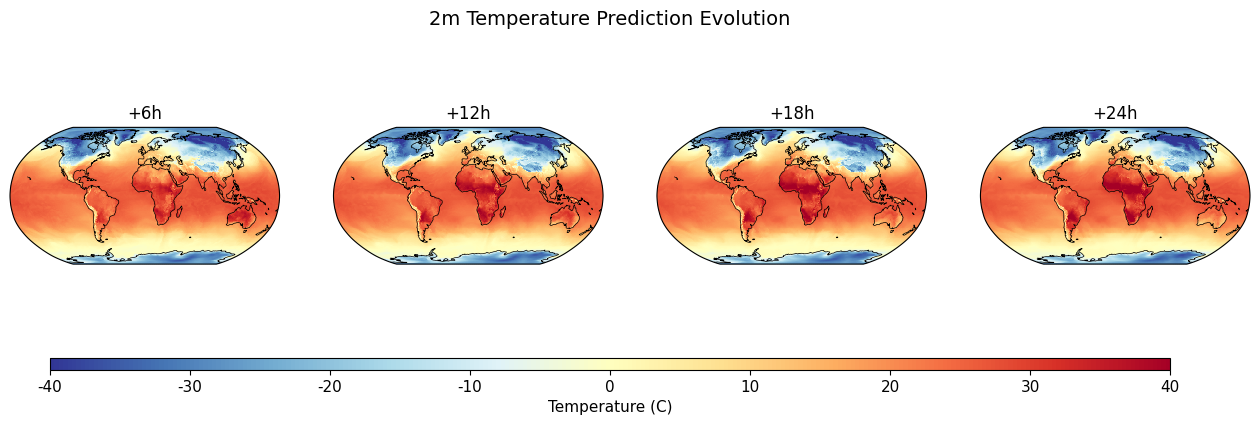


 第一步预测 vs Ground Truth 对比 (+6h)
图片已保存: /content/outputs/prediction_comparison_global.png


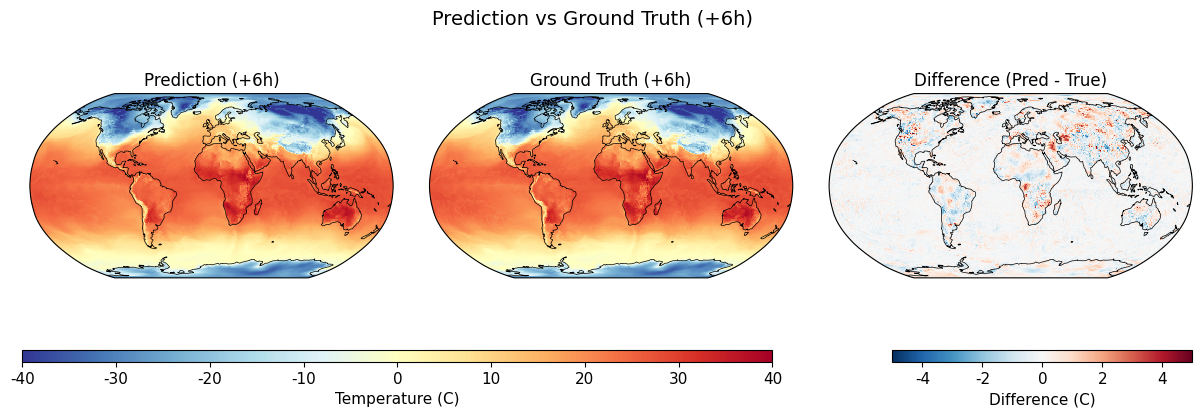


误差统计 (+6h):
  RMSE: 0.568 C
  MAE:  0.361 C


In [ ]:
#@title ## 4.1 全球温度预测可视化
#@markdown 展示预测结果
#@markdown
#@markdown **注意**: 根据数据时间步不同，可能无法提供完整的 ground truth 对比。
#@markdown 这里主要展示预测结果的演变过程。

print("=" * 60)
print(" 预测数据检查")
print("=" * 60)

# 检查预测数据
pred_temp = predictions_multi['2m_temperature']
if 'batch' in pred_temp.dims:
    pred_temp = pred_temp.isel(batch=0)

# 转换为摄氏度
pred_temp_C = pred_temp - 273.15
print(f"预测温度范围: {float(pred_temp_C.min()):.2f} ~ {float(pred_temp_C.max()):.2f} C")

# 获取 ground truth（原始数据最后一个时间步）
true_temp_raw = example_batch['2m_temperature'].isel(time=-1, batch=0)
true_temp_C = true_temp_raw - 273.15
print(f"Ground Truth 温度范围: {float(true_temp_C.min()):.2f} ~ {float(true_temp_C.max()):.2f} C")

print("=" * 60)

# ============ 图1: 预测演变 ============
num_steps_to_show = min(4, len(predictions_multi.time))

fig1 = plt.figure(figsize=(4*num_steps_to_show, 4))

for i in range(num_steps_to_show):
    ax = fig1.add_subplot(1, num_steps_to_show, i+1, projection=ccrs.Robinson())
    data = pred_temp_C.isel(time=i)

    im = ax.pcolormesh(
        data.lon, data.lat, data.values,
        transform=ccrs.PlateCarree(),
        cmap='RdYlBu_r',
        vmin=-40, vmax=40,
        shading='auto'
    )
    ax.coastlines(linewidth=0.5)
    ax.set_title(f'+{(i+1)*6}h', fontsize=12)

# 在底部添加共用 colorbar
fig1.subplots_adjust(bottom=0.15)
cbar_ax = fig1.add_axes([0.15, 0.08, 0.7, 0.03])  # [left, bottom, width, height]
cbar = fig1.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Temperature (C)', fontsize=11)

fig1.suptitle('2m Temperature Prediction Evolution', fontsize=14, y=0.98)

save_path1 = f"{OUTPUT_DIR}/prediction_evolution.png"
fig1.savefig(save_path1, dpi=150, bbox_inches='tight')
print(f"\n图片已保存: {save_path1}")
plt.show()

# ============ 图2: 预测 vs Ground Truth 对比 ============
print("\n" + "=" * 60)
print(" 第一步预测 vs Ground Truth 对比 (+6h)")
print("=" * 60)

fig2 = plt.figure(figsize=(15, 4))

# 子图1: 预测
ax1 = fig2.add_subplot(1, 3, 1, projection=ccrs.Robinson())
pred_step0 = pred_temp_C.isel(time=0)
im1 = ax1.pcolormesh(
    pred_step0.lon, pred_step0.lat, pred_step0.values,
    transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r', vmin=-40, vmax=40, shading='auto'
)
ax1.coastlines(linewidth=0.5)
ax1.set_title('Prediction (+6h)', fontsize=12)

# 子图2: Ground Truth
ax2 = fig2.add_subplot(1, 3, 2, projection=ccrs.Robinson())
im2 = ax2.pcolormesh(
    true_temp_C.lon, true_temp_C.lat, true_temp_C.values,
    transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r', vmin=-40, vmax=40, shading='auto'
)
ax2.coastlines(linewidth=0.5)
ax2.set_title('Ground Truth (+6h)', fontsize=12)

# 子图3: 差异
ax3 = fig2.add_subplot(1, 3, 3, projection=ccrs.Robinson())
diff = pred_step0.values - true_temp_C.values
im3 = ax3.pcolormesh(
    pred_step0.lon, pred_step0.lat, diff,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r', vmin=-5, vmax=5, shading='auto'
)
ax3.coastlines(linewidth=0.5)
ax3.set_title('Difference (Pred - True)', fontsize=12)

# 调整子图间距
fig2.subplots_adjust(bottom=0.2, wspace=0.1)

# colorbar 1: 温度 (前两张图共用)
cbar_ax1 = fig2.add_axes([0.12, 0.1, 0.5, 0.03])
cbar1 = fig2.colorbar(im1, cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('Temperature (C)')

# colorbar 2: 差异
cbar_ax2 = fig2.add_axes([0.7, 0.1, 0.2, 0.03])
cbar2 = fig2.colorbar(im3, cax=cbar_ax2, orientation='horizontal')
cbar2.set_label('Difference (C)')

fig2.suptitle('Prediction vs Ground Truth (+6h)', fontsize=14, y=0.98)

save_path2 = f"{OUTPUT_DIR}/prediction_comparison_global.png"
fig2.savefig(save_path2, dpi=150, bbox_inches='tight')
print(f"图片已保存: {save_path2}")
plt.show()

# 误差统计
rmse = float(np.sqrt(np.nanmean(diff**2)))
mae = float(np.nanmean(np.abs(diff)))
print(f"\n误差统计 (+6h):")
print(f"  RMSE: {rmse:.3f} C")
print(f"  MAE:  {mae:.3f} C")

纬度排列: 升序
预测数据形状: (4, 5, 7)
Ground Truth 形状: (5, 7)

图片已保存: /content/outputs/prediction_comparison_china.png


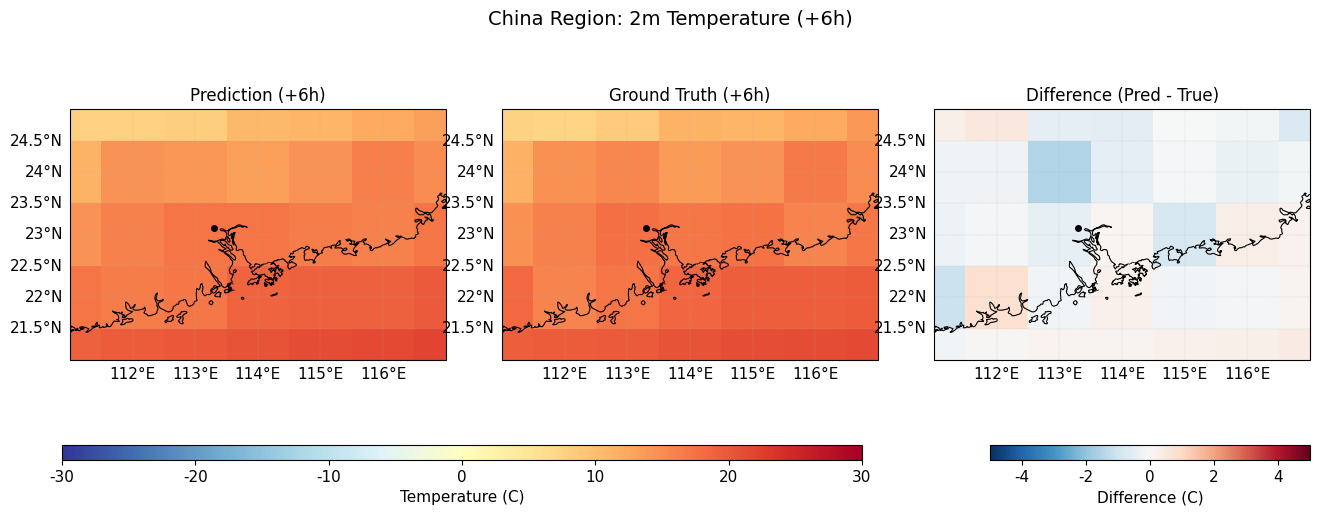


中国区域误差统计 (+6h):
  RMSE: 0.470 C
  MAE:  0.350 C


In [ ]:
#@title ## 4.2 中国区域预测对比
#@markdown 聚焦中国区域的预测结果

# 使用之前定义的预测数据 (pred_temp_C) 和 ground truth (true_temp_C)
# 如果没有定义，重新获取
if 'pred_temp_C' not in dir():
    pred_temp = predictions_multi['2m_temperature']
    if 'batch' in pred_temp.dims:
        pred_temp = pred_temp.isel(batch=0)
    pred_temp_C = pred_temp - 273.15

if 'true_temp_C' not in dir():
    true_temp_raw = example_batch['2m_temperature'].isel(time=-1, batch=0)
    true_temp_C = true_temp_raw - 273.15

# 检查纬度排列顺序
lat_ascending = float(pred_temp_C.lat[0]) < float(pred_temp_C.lat[-1])

if lat_ascending:
    lat_slice = slice(lat_min, lat_max)
else:
    lat_slice = slice(lat_max, lat_min)

print(f"纬度排列: {'升序' if lat_ascending else '降序'}")

# 裁剪到中国区域
pred_china = pred_temp_C.sel(lon=slice(lon_min, lon_max), lat=lat_slice)
true_china = true_temp_C.sel(lon=slice(lon_min, lon_max), lat=lat_slice)

# 检查数据
print(f"预测数据形状: {pred_china.shape}")
print(f"Ground Truth 形状: {true_china.shape}")

if pred_china.size == 0:
    print("[!] 裁剪后数据为空，使用 where 方法...")
    lon_mask = (pred_temp_C.lon >= lon_min) & (pred_temp_C.lon <= lon_max)
    lat_mask = (pred_temp_C.lat >= lat_min) & (pred_temp_C.lat <= lat_max)
    pred_china = pred_temp_C.where(lon_mask & lat_mask, drop=True)
    true_china = true_temp_C.where(lon_mask & lat_mask, drop=True)
    print(f"重新裁剪后形状: {pred_china.shape}")

# 选择时间步 (第一步用于与 ground truth 对比)
step_idx = 0

# 使用 PlateCarree 投影 (避免倾斜)
fig = plt.figure(figsize=(16, 5))

# 子图1: 预测
ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

im1 = ax1.pcolormesh(
    pred_china.lon, pred_china.lat,
    pred_china.isel(time=step_idx).values,
    transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r', vmin=-30, vmax=30,
    shading='auto'
)
ax1.coastlines(linewidth=0.8)
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.set_title('Prediction (+6h)', fontsize=12)

# 添加网格线
gl1 = ax1.gridlines(draw_labels=True, linewidth=0.3, alpha=0.5, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

# 子图2: Ground Truth
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

im2 = ax2.pcolormesh(
    true_china.lon, true_china.lat,
    true_china.values,
    transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r', vmin=-30, vmax=30,
    shading='auto'
)
ax2.coastlines(linewidth=0.8)
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.set_title('Ground Truth (+6h)', fontsize=12)

gl2 = ax2.gridlines(draw_labels=True, linewidth=0.3, alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

# 子图3: 差异
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
ax3.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

diff_china = pred_china.isel(time=step_idx).values - true_china.values
im3 = ax3.pcolormesh(
    pred_china.lon, pred_china.lat, diff_china,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r', vmin=-5, vmax=5,
    shading='auto'
)
ax3.coastlines(linewidth=0.8)
ax3.add_feature(cfeature.BORDERS, linewidth=0.5)
ax3.set_title('Difference (Pred - True)', fontsize=12)

gl3 = ax3.gridlines(draw_labels=True, linewidth=0.3, alpha=0.5, linestyle='--')
gl3.top_labels = False
gl3.right_labels = False

# 标注城市
if 'cities' in dir():
    for ax in [ax1, ax2, ax3]:
        for city, (clon, clat) in cities.items():
            ax.plot(clon, clat, 'ko', markersize=4, transform=ccrs.PlateCarree())

# 调整布局
fig.subplots_adjust(bottom=0.18, wspace=0.15)

# Colorbar 1: 温度
cbar_ax1 = fig.add_axes([0.12, 0.08, 0.5, 0.03])
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('Temperature (C)')

# Colorbar 2: 差异
cbar_ax2 = fig.add_axes([0.7, 0.08, 0.2, 0.03])
cbar2 = fig.colorbar(im3, cax=cbar_ax2, orientation='horizontal')
cbar2.set_label('Difference (C)')

fig.suptitle('China Region: 2m Temperature (+6h)', fontsize=14, y=0.98)

# 保存
save_path = f"{OUTPUT_DIR}/prediction_comparison_china.png"
fig.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"\n图片已保存: {save_path}")

plt.show()

# 误差统计
rmse_china = float(np.sqrt(np.nanmean(diff_china**2)))
mae_china = float(np.nanmean(np.abs(diff_china)))
print(f"\n中国区域误差统计 (+6h):")
print(f"  RMSE: {rmse_china:.3f} C")
print(f"  MAE:  {mae_china:.3f} C")

正在生成动画...
动画帧数: 4
正在保存 GIF...
动画已保存: /content/outputs/temperature_forecast_animation.gif

动画预览:


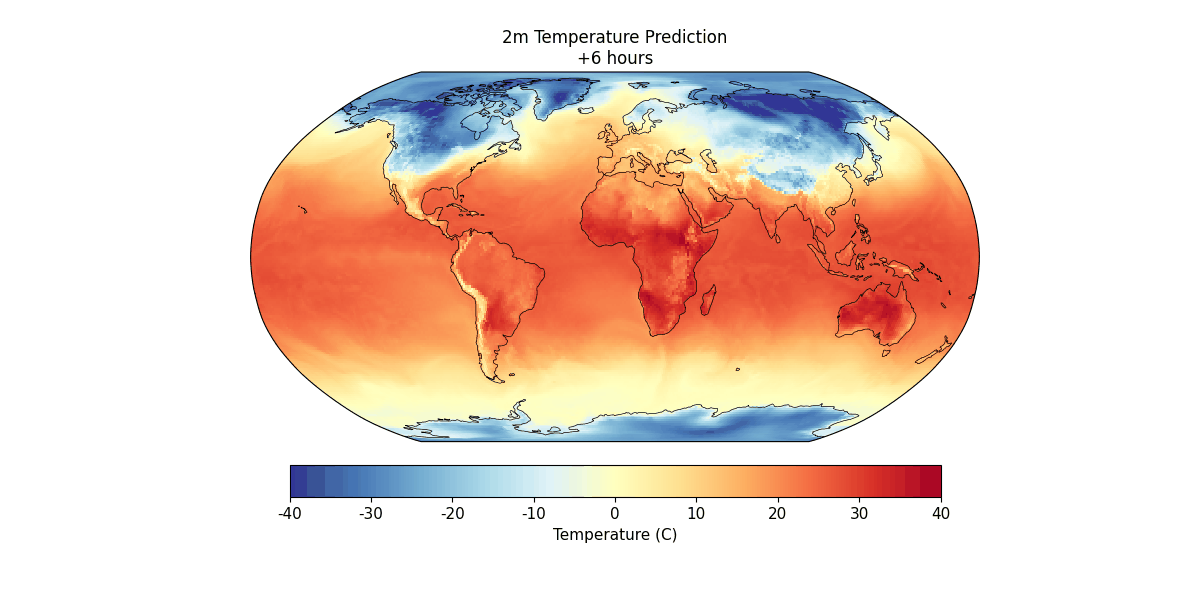

In [ ]:
#@title ## 4.3 预测动画（全球温度演变）
#@markdown 生成预测结果的动画
#@markdown

from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image

print("正在生成动画...")

# 确保使用正确的数据
if 'pred_temp_C' not in dir():
    pred_temp = predictions_multi['2m_temperature']
    if 'batch' in pred_temp.dims:
        pred_temp = pred_temp.isel(batch=0)
    pred_temp_C = pred_temp - 273.15

n_frames = len(pred_temp_C.time)
print(f"动画帧数: {n_frames}")

# 创建图形
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# 绑定第一帧数据以创建 colorbar
data_0 = pred_temp_C.isel(time=0).values
im = ax.pcolormesh(
    pred_temp_C.lon, pred_temp_C.lat, data_0,
    transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r', vmin=-40, vmax=40,
    shading='auto'
)
ax.coastlines(linewidth=0.5)

# 添加 colorbar
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.7)
cbar.set_label('Temperature (C)')

title = ax.set_title(f'2m Temperature Prediction\n+6 hours', fontsize=12)

# 更新函数
def update(frame):
    # 更新数据
    data = pred_temp_C.isel(time=frame).values
    im.set_array(data.ravel())
    title.set_text(f'2m Temperature Prediction\n+{(frame+1)*6} hours')
    return [im, title]

# 创建动画
anim = FuncAnimation(
    fig, update, frames=n_frames,
    blit=False, interval=500, repeat=True
)

# 保存为 GIF
gif_path = f"{OUTPUT_DIR}/temperature_forecast_animation.gif"
print("正在保存 GIF...")
anim.save(gif_path, writer='pillow', fps=2)
print(f"动画已保存: {gif_path}")

plt.close()

# 显示动画
print("\n动画预览:")
display(Image(filename=gif_path))

 第一步预测误差 (+6h)
  RMSE: 0.568 C
  MAE:  0.361 C

图片已保存: /content/outputs/prediction_analysis.png


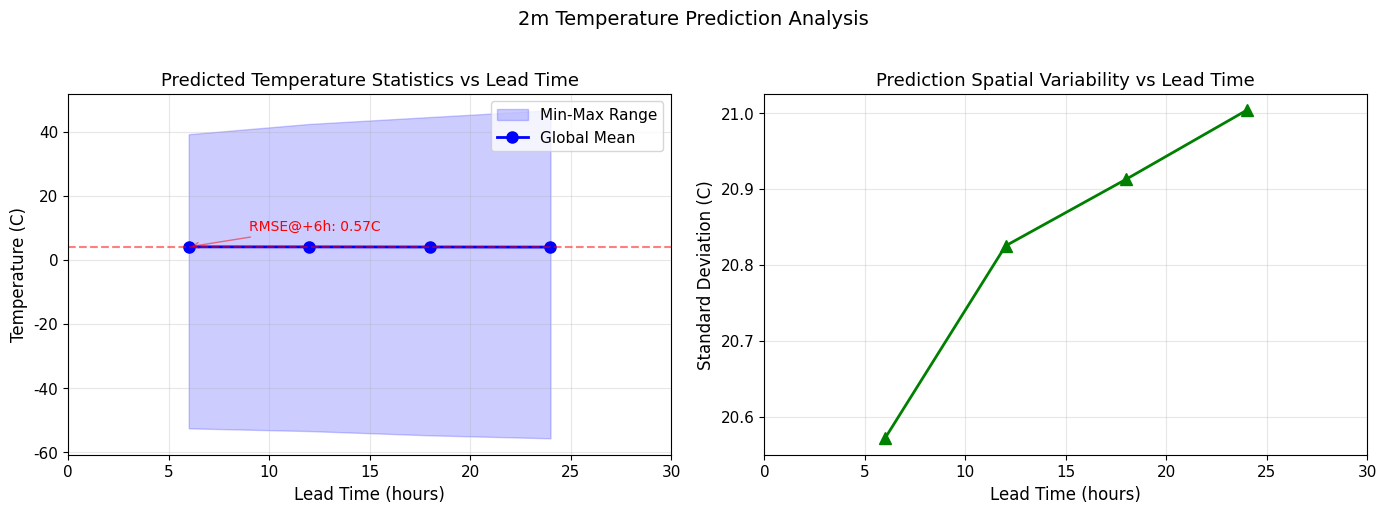


预测统计表:
------------------------------------------------------------
Lead Time    Mean (C)     Std (C)      Min (C)      Max (C)     
------------------------------------------------------------
6            4.03         20.57        -52.57       39.16       
12           4.02         20.83        -53.42       42.36       
18           3.98         20.91        -54.75       44.52       
24           3.95         21.00        -55.68       46.64       
------------------------------------------------------------

* 仅第一步 (+6h) 可与 Ground Truth 对比，RMSE = 0.568 C


In [ ]:
#@title ## 4.4 预测分析
#@markdown 分析全球预测结果随时间的变化

# 确保数据存在
if 'pred_temp_C' not in dir():
    pred_temp = predictions_multi['2m_temperature']
    if 'batch' in pred_temp.dims:
        pred_temp = pred_temp.isel(batch=0)
    pred_temp_C = pred_temp - 273.15

if 'true_temp_C' not in dir():
    true_temp_raw = example_batch['2m_temperature'].isel(time=-1, batch=0)
    true_temp_C = true_temp_raw - 273.15

n_steps = len(pred_temp_C.time)
lead_times = [(t + 1) * 6 for t in range(n_steps)]

# 计算每个时间步的统计量
stats = {
    'lead_time': lead_times,
    'mean': [],
    'std': [],
    'min': [],
    'max': []
}

for t in range(n_steps):
    data = pred_temp_C.isel(time=t).values
    stats['mean'].append(float(np.nanmean(data)))
    stats['std'].append(float(np.nanstd(data)))
    stats['min'].append(float(np.nanmin(data)))
    stats['max'].append(float(np.nanmax(data)))

# 第一步的误差
diff_step0 = pred_temp_C.isel(time=0).values - true_temp_C.values
rmse_step0 = float(np.sqrt(np.nanmean(diff_step0**2)))
mae_step0 = float(np.nanmean(np.abs(diff_step0)))

print("=" * 50)
print(" 第一步预测误差 (+6h)")
print("=" * 50)
print(f"  RMSE: {rmse_step0:.3f} C")
print(f"  MAE:  {mae_step0:.3f} C")
print("=" * 50)

# ============ 可视化 ============
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 图1: 预测温度范围随时间变化
ax1 = axes[0]
ax1.fill_between(lead_times, stats['min'], stats['max'], alpha=0.2, color='blue', label='Min-Max Range')
ax1.plot(lead_times, stats['mean'], 'b-o', linewidth=2, markersize=8, label='Global Mean')
ax1.set_xlabel('Lead Time (hours)', fontsize=12)
ax1.set_ylabel('Temperature (C)', fontsize=12)
ax1.set_title('Predicted Temperature Statistics vs Lead Time', fontsize=13)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, max(lead_times) + 6])

# 图2: 标准差随时间变化
ax2 = axes[1]
ax2.plot(lead_times, stats['std'], 'g-^', linewidth=2, markersize=8)
ax2.set_xlabel('Lead Time (hours)', fontsize=12)
ax2.set_ylabel('Standard Deviation (C)', fontsize=12)
ax2.set_title('Prediction Spatial Variability vs Lead Time', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, max(lead_times) + 6])

# 在图上标注第一步误差
ax1.axhline(y=stats['mean'][0], color='red', linestyle='--', alpha=0.5)
ax1.annotate(f'RMSE@+6h: {rmse_step0:.2f}C',
             xy=(lead_times[0], stats['mean'][0]),
             xytext=(lead_times[0]+3, stats['mean'][0]+5),
             fontsize=10, color='red',
             arrowprops=dict(arrowstyle='->', color='red', alpha=0.5))

plt.suptitle('2m Temperature Prediction Analysis', fontsize=14, y=1.02)
plt.tight_layout()

# 保存
save_path = f"{OUTPUT_DIR}/prediction_analysis.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"\n图片已保存: {save_path}")

plt.show()

# 打印统计表格
print("\n预测统计表:")
print("-" * 60)
print(f"{'Lead Time':<12} {'Mean (C)':<12} {'Std (C)':<12} {'Min (C)':<12} {'Max (C)':<12}")
print("-" * 60)
for i, lt in enumerate(lead_times):
    print(f"{lt:<12} {stats['mean'][i]:<12.2f} {stats['std'][i]:<12.2f} {stats['min'][i]:<12.2f} {stats['max'][i]:<12.2f}")
print("-" * 60)
print(f"\n* 仅第一步 (+6h) 可与 Ground Truth 对比，RMSE = {rmse_step0:.3f} C")

城市: Beijing
坐标: (116.4E, 39.9N)
Ground Truth (+6h): -2.08 C

图片已保存: /content/outputs/city_forecast_Beijing.png


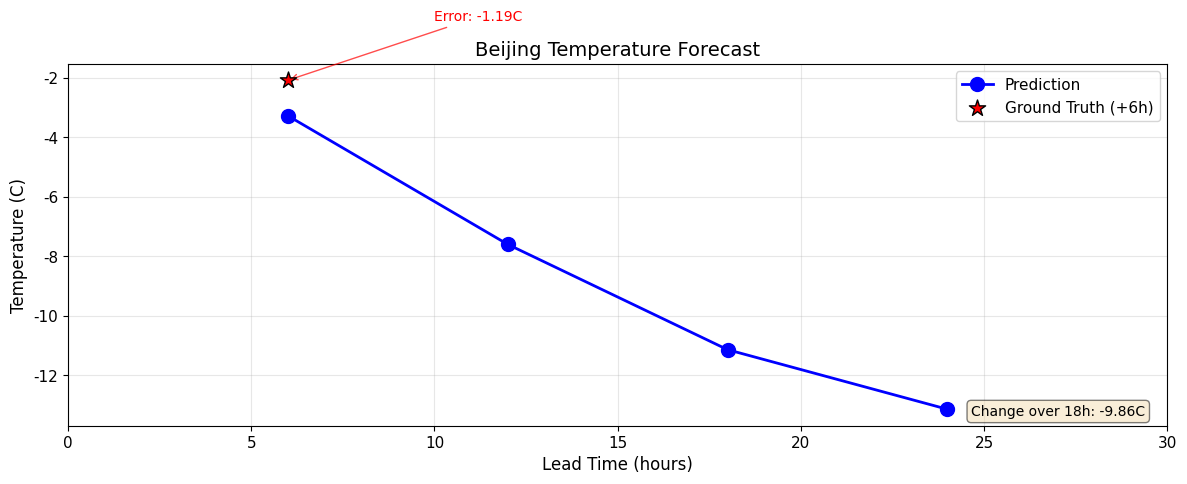


Beijing 预测统计:
  预测温度 (+6h):  -3.27 C
  实际温度 (+6h):  -2.08 C
  误差 (+6h):      -1.19 C
  预测温度 (+24h): -13.14 C


In [ ]:
#@title ## 4.5 城市温度预测时序图
#@markdown 查看主要城市的温度预测时间序列
#@markdown
#@markdown ---
#@markdown ### 选择城市
#@markdown
#@markdown **注意**: 只有 +6h 有 Ground Truth 可对比

selected_city = "Shanghai" #@param ["Beijing", "Shanghai", "Guangzhou", "Chengdu", "Haerbin", "Wulumuqi"]

# 确保数据存在
if 'pred_temp_C' not in dir():
    pred_temp = predictions_multi['2m_temperature']
    if 'batch' in pred_temp.dims:
        pred_temp = pred_temp.isel(batch=0)
    pred_temp_C = pred_temp - 273.15

if 'true_temp_C' not in dir():
    true_temp_raw = example_batch['2m_temperature'].isel(time=-1, batch=0)
    true_temp_C = true_temp_raw - 273.15

city_lon, city_lat = cities[selected_city]

# 提取该城市的预测时间序列
pred_city = pred_temp_C.sel(lon=city_lon, lat=city_lat, method='nearest')

# 提取 ground truth (只有 +6h 一个点)
true_city_value = float(true_temp_C.sel(lon=city_lon, lat=city_lat, method='nearest').values)

print(f"城市: {selected_city}")
print(f"坐标: ({city_lon}E, {city_lat}N)")
print(f"Ground Truth (+6h): {true_city_value:.2f} C")

# 绘图
fig, ax = plt.subplots(figsize=(12, 5))

lead_hours = [(i + 1) * 6 for i in range(len(pred_city.time))]
pred_values = pred_city.values

# 预测曲线
ax.plot(lead_hours, pred_values, 'b-o', linewidth=2, markersize=10, label='Prediction', zorder=3)

# Ground Truth 点 (只有 +6h)
ax.scatter([6], [true_city_value], color='red', s=150, marker='*',
           label='Ground Truth (+6h)', zorder=4, edgecolors='black', linewidths=1)

# 第一步误差
error_6h = pred_values[0] - true_city_value
ax.annotate(f'Error: {error_6h:+.2f}C',
            xy=(6, true_city_value),
            xytext=(10, true_city_value + 2),
            fontsize=10, color='red',
            arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))

ax.set_xlabel('Lead Time (hours)', fontsize=12)
ax.set_ylabel('Temperature (C)', fontsize=12)
ax.set_title(f'{selected_city} Temperature Forecast', fontsize=14)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, max(lead_hours) + 6])

# 添加预测变化趋势标注
temp_change = pred_values[-1] - pred_values[0]
ax.annotate(f'Change over {max(lead_hours)-6}h: {temp_change:+.2f}C',
            xy=(0.98, 0.02), xycoords='axes fraction',
            ha='right', va='bottom', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()

# 保存图片
save_path = f"{OUTPUT_DIR}/city_forecast_{selected_city}.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"\n图片已保存: {save_path}")

plt.show()

# 统计
print(f"\n{selected_city} 预测统计:")
print(f"  预测温度 (+6h):  {pred_values[0]:.2f} C")
print(f"  实际温度 (+6h):  {true_city_value:.2f} C")
print(f"  误差 (+6h):      {error_6h:+.2f} C")
print(f"  预测温度 (+{max(lead_hours)}h): {pred_values[-1]:.2f} C")

---
<a id='第五部分'></a>
# 第五部分: 参数实验

本部分将进行各种参数实验，探索模型的行为。

计算各变量预测误差 (+6h)...
--------------------------------------------------
  2m Temperature: RMSE = 0.5678 K
  Sea Level Pressure: RMSE = 41.9335 Pa
  10m U Wind: RMSE = 0.6301 m/s
  10m V Wind: RMSE = 0.6400 m/s
--------------------------------------------------

图片已保存: /content/outputs/rmse_by_variable.png


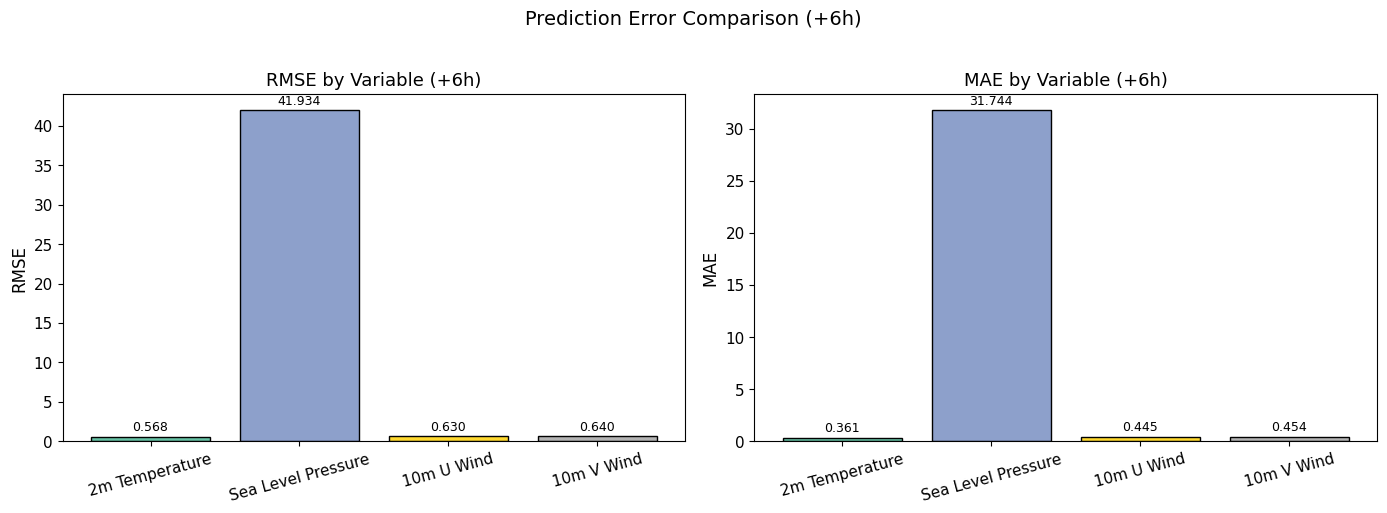


误差统计表 (+6h):
-------------------------------------------------------
Variable                  RMSE         MAE          Unit    
-------------------------------------------------------
2m Temperature            0.5678       0.3613       K       
Sea Level Pressure        41.9335      31.7439      Pa      
10m U Wind                0.6301       0.4453       m/s     
10m V Wind                0.6400       0.4545       m/s     
-------------------------------------------------------


In [ ]:
#@title ## 5.1 不同变量的预测精度对比
#@markdown 比较不同气象变量的预测精度
#@markdown
#@markdown **注意**: 只有 +6h 有 Ground Truth，因此只计算第一步误差

# 定义要比较的变量
variables_to_compare = [
    ('2m_temperature', 'K', '2m Temperature'),
    ('mean_sea_level_pressure', 'Pa', 'Sea Level Pressure'),
    ('10m_u_component_of_wind', 'm/s', '10m U Wind'),
    ('10m_v_component_of_wind', 'm/s', '10m V Wind'),
]

# 从原始数据获取 ground truth (+6h)
true_data = example_batch.isel(time=-1, batch=0)

# 计算每个变量在 +6h 的 RMSE
variable_errors = {}

print("计算各变量预测误差 (+6h)...")
print("-" * 50)

for var_name, unit, display_name in variables_to_compare:
    if var_name in predictions_multi.data_vars and var_name in true_data.data_vars:
        pred_var = predictions_multi[var_name].isel(time=0)  # +6h 预测
        if 'batch' in pred_var.dims:
            pred_var = pred_var.isel(batch=0)

        true_var = true_data[var_name]  # +6h ground truth

        # 计算误差
        diff = pred_var.values - true_var.values
        rmse = float(np.sqrt(np.nanmean(diff**2)))
        mae = float(np.nanmean(np.abs(diff)))

        variable_errors[display_name] = {
            'rmse': rmse,
            'mae': mae,
            'unit': unit
        }
        print(f"  {display_name}: RMSE = {rmse:.4f} {unit}")

print("-" * 50)

# ============ 可视化 ============
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

var_names = list(variable_errors.keys())
rmse_values = [variable_errors[v]['rmse'] for v in var_names]
mae_values = [variable_errors[v]['mae'] for v in var_names]
colors = plt.cm.Set2(np.linspace(0, 1, len(var_names)))

# 图1: RMSE 柱状图
ax1 = axes[0]
bars1 = ax1.bar(var_names, rmse_values, color=colors, edgecolor='black', linewidth=1)
ax1.set_ylabel('RMSE', fontsize=12)
ax1.set_title('RMSE by Variable (+6h)', fontsize=13)
ax1.tick_params(axis='x', rotation=15)

# 在柱子上标注数值
for bar, val, var in zip(bars1, rmse_values, var_names):
    unit = variable_errors[var]['unit']
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(rmse_values),
             f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# 图2: MAE 柱状图
ax2 = axes[1]
bars2 = ax2.bar(var_names, mae_values, color=colors, edgecolor='black', linewidth=1)
ax2.set_ylabel('MAE', fontsize=12)
ax2.set_title('MAE by Variable (+6h)', fontsize=13)
ax2.tick_params(axis='x', rotation=15)

for bar, val, var in zip(bars2, mae_values, var_names):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(mae_values),
             f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Prediction Error Comparison (+6h)', fontsize=14, y=1.02)
plt.tight_layout()

# 保存
save_path = f"{OUTPUT_DIR}/rmse_by_variable.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"\n图片已保存: {save_path}")

plt.show()

# 打印表格
print("\n误差统计表 (+6h):")
print("-" * 55)
print(f"{'Variable':<25} {'RMSE':<12} {'MAE':<12} {'Unit':<8}")
print("-" * 55)
for var, data in variable_errors.items():
    print(f"{var:<25} {data['rmse']:<12.4f} {data['mae']:<12.4f} {data['unit']:<8}")
print("-" * 55)

纬度排列: 升序

计算各区域预测误差 (+6h)...
--------------------------------------------------
  Global: RMSE = 0.568 C
  China: RMSE = 1.031 C
  Europe: RMSE = 0.713 C
  [!] North America: 数据为空，跳过
  Tropics: RMSE = 0.457 C
  Arctic: RMSE = 0.705 C
--------------------------------------------------

图片已保存: /content/outputs/rmse_by_region.png


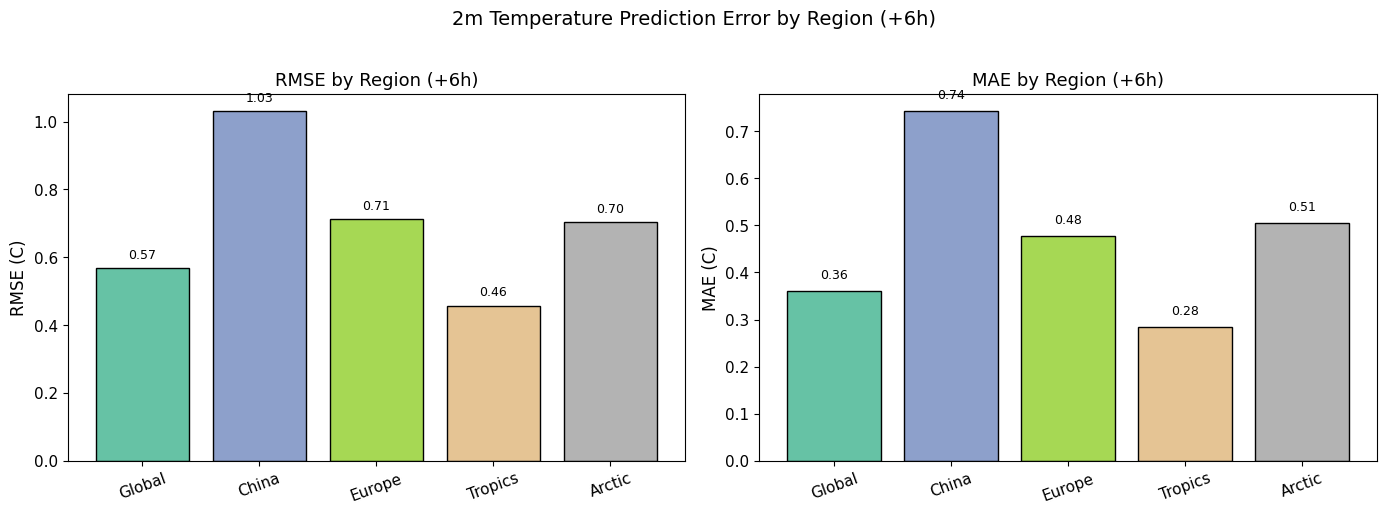


各区域误差统计 (+6h):
---------------------------------------------
Region             RMSE (C)     MAE (C)     
---------------------------------------------
Global             0.568        0.361       
China              1.031        0.742       
Europe             0.713        0.478       
Tropics            0.457        0.285       
Arctic             0.705        0.505       
---------------------------------------------


In [ ]:
#@title ## 5.2 不同区域的预测精度对比
#@markdown 比较不同地理区域的预测误差 (+6h)

# 确保数据存在
if 'pred_temp_C' not in dir():
    pred_temp = predictions_multi['2m_temperature']
    if 'batch' in pred_temp.dims:
        pred_temp = pred_temp.isel(batch=0)
    pred_temp_C = pred_temp - 273.15

if 'true_temp_C' not in dir():
    true_temp_raw = example_batch['2m_temperature'].isel(time=-1, batch=0)
    true_temp_C = true_temp_raw - 273.15

# 检查纬度排列顺序
lat_ascending = float(pred_temp_C.lat[0]) < float(pred_temp_C.lat[-1])
print(f"纬度排列: {'升序' if lat_ascending else '降序'}")

# 定义区域 (根据纬度顺序调整 slice)
if lat_ascending:
    regions = {
        'Global': {'lon': slice(None), 'lat': slice(None)},
        'China': {'lon': slice(73, 135), 'lat': slice(18, 54)},
        'Europe': {'lon': slice(-10, 40), 'lat': slice(35, 70)},
        'North America': {'lon': slice(-130, -60), 'lat': slice(25, 55)},
        'Tropics': {'lon': slice(None), 'lat': slice(-23, 23)},
        'Arctic': {'lon': slice(None), 'lat': slice(66, 90)},
    }
else:
    regions = {
        'Global': {'lon': slice(None), 'lat': slice(None)},
        'China': {'lon': slice(73, 135), 'lat': slice(54, 18)},
        'Europe': {'lon': slice(-10, 40), 'lat': slice(70, 35)},
        'North America': {'lon': slice(-130, -60), 'lat': slice(55, 25)},
        'Tropics': {'lon': slice(None), 'lat': slice(23, -23)},
        'Arctic': {'lon': slice(None), 'lat': slice(90, 66)},
    }

# 计算各区域 +6h 误差
region_errors = {}

print("\n计算各区域预测误差 (+6h)...")
print("-" * 50)

# 使用第一步预测 (+6h)
pred_step0 = pred_temp_C.isel(time=0)

for region_name, bounds in regions.items():
    try:
        pred_region = pred_step0.sel(**bounds)
        true_region = true_temp_C.sel(**bounds)

        if pred_region.size == 0:
            print(f"  [!] {region_name}: 数据为空，跳过")
            continue

        diff = pred_region.values - true_region.values
        rmse = float(np.sqrt(np.nanmean(diff**2)))
        mae = float(np.nanmean(np.abs(diff)))

        region_errors[region_name] = {'rmse': rmse, 'mae': mae}
        print(f"  {region_name}: RMSE = {rmse:.3f} C")
    except Exception as e:
        print(f"  [!] {region_name}: 错误 - {e}")

print("-" * 50)

# ============ 可视化 ============
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

region_names = list(region_errors.keys())
rmse_values = [region_errors[r]['rmse'] for r in region_names]
mae_values = [region_errors[r]['mae'] for r in region_names]
colors = plt.cm.Set2(np.linspace(0, 1, len(region_names)))

# 图1: RMSE 柱状图
ax1 = axes[0]
bars1 = ax1.bar(region_names, rmse_values, color=colors, edgecolor='black', linewidth=1)
ax1.set_ylabel('RMSE (C)', fontsize=12)
ax1.set_title('RMSE by Region (+6h)', fontsize=13)
ax1.tick_params(axis='x', rotation=20)

for bar, val in zip(bars1, rmse_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{val:.2f}', ha='center', va='bottom', fontsize=9)

# 图2: MAE 柱状图
ax2 = axes[1]
bars2 = ax2.bar(region_names, mae_values, color=colors, edgecolor='black', linewidth=1)
ax2.set_ylabel('MAE (C)', fontsize=12)
ax2.set_title('MAE by Region (+6h)', fontsize=13)
ax2.tick_params(axis='x', rotation=20)

for bar, val in zip(bars2, mae_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('2m Temperature Prediction Error by Region (+6h)', fontsize=14, y=1.02)
plt.tight_layout()

# 保存
save_path = f"{OUTPUT_DIR}/rmse_by_region.png"
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"\n图片已保存: {save_path}")

plt.show()

# 打印表格
print("\n各区域误差统计 (+6h):")
print("-" * 45)
print(f"{'Region':<18} {'RMSE (C)':<12} {'MAE (C)':<12}")
print("-" * 45)
for region_name, data in region_errors.items():
    print(f"{region_name:<18} {data['rmse']:<12.3f} {data['mae']:<12.3f}")
print("-" * 45)

气压层数: 13
气压层: [  50  100  150  200  250  300  400  500  600  700  850  925 1000]

计算各气压层预测误差 (+6h)...
--------------------------------------------------
计算完成
--------------------------------------------------

图片已保存: /content/outputs/rmse_by_pressure_level.png


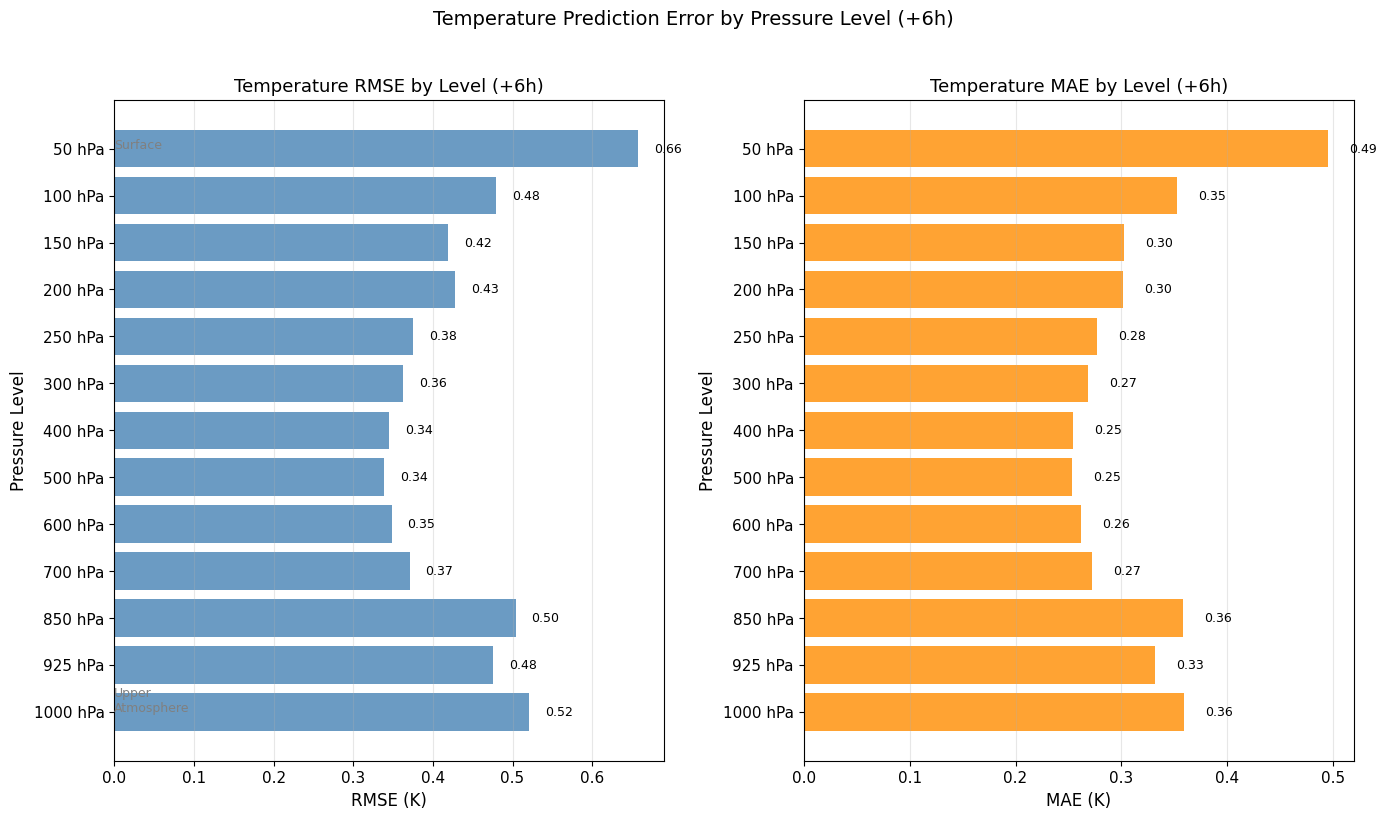


各气压层误差统计 (+6h):
---------------------------------------------
Level (hPa)     RMSE (K)     MAE (K)     
---------------------------------------------
1000            0.520        0.359       
925             0.475        0.331       
850             0.504        0.358       
700             0.371        0.272       
600             0.348        0.262       
500             0.338        0.254       
400             0.345        0.255       
300             0.363        0.268       
250             0.375        0.277       
200             0.428        0.302       
150             0.419        0.302       
100             0.480        0.352       
50              0.658        0.495       
---------------------------------------------


In [ ]:
#@title ## 5.3 不同气压层的预测精度
#@markdown 分析不同高度层的温度预测误差 (+6h)

# 检查是否有多层数据
if 'level' in predictions_multi.dims and 'temperature' in predictions_multi.data_vars:

    # 获取预测数据 (+6h)
    pred_temp_levels = predictions_multi['temperature'].isel(time=0)
    if 'batch' in pred_temp_levels.dims:
        pred_temp_levels = pred_temp_levels.isel(batch=0)

    # 获取 ground truth (从原始数据)
    if 'temperature' in example_batch.data_vars:
        true_temp_levels = example_batch['temperature'].isel(time=-1, batch=0)

        levels = pred_temp_levels.level.values
        print(f"气压层数: {len(levels)}")
        print(f"气压层: {levels}")

        # 计算各层的 RMSE (+6h)
        level_errors = {}

        print("\n计算各气压层预测误差 (+6h)...")
        print("-" * 50)

        for level in levels:
            pred_level = pred_temp_levels.sel(level=level)
            true_level = true_temp_levels.sel(level=level)

            diff = pred_level.values - true_level.values
            rmse = float(np.sqrt(np.nanmean(diff**2)))
            mae = float(np.nanmean(np.abs(diff)))

            level_errors[level] = {'rmse': rmse, 'mae': mae}

        print("计算完成")
        print("-" * 50)

        # ============ 可视化 ============
        fig, axes = plt.subplots(1, 2, figsize=(14, 8))

        levels_sorted = sorted(level_errors.keys(), reverse=True)  # 从高压(地面)到低压(高空)
        rmse_values = [level_errors[l]['rmse'] for l in levels_sorted]
        mae_values = [level_errors[l]['mae'] for l in levels_sorted]

        # 图1: RMSE
        ax1 = axes[0]
        bars1 = ax1.barh(range(len(levels_sorted)), rmse_values, color='steelblue', alpha=0.8)
        ax1.set_yticks(range(len(levels_sorted)))
        ax1.set_yticklabels([f"{int(l)} hPa" for l in levels_sorted])
        ax1.set_xlabel('RMSE (K)', fontsize=12)
        ax1.set_ylabel('Pressure Level', fontsize=12)
        ax1.set_title('Temperature RMSE by Level (+6h)', fontsize=13)
        ax1.grid(True, alpha=0.3, axis='x')

        # 标注数值
        for bar, val in zip(bars1, rmse_values):
            ax1.text(val + 0.02, bar.get_y() + bar.get_height()/2,
                     f'{val:.2f}', va='center', fontsize=9)

        # 图2: MAE
        ax2 = axes[1]
        bars2 = ax2.barh(range(len(levels_sorted)), mae_values, color='darkorange', alpha=0.8)
        ax2.set_yticks(range(len(levels_sorted)))
        ax2.set_yticklabels([f"{int(l)} hPa" for l in levels_sorted])
        ax2.set_xlabel('MAE (K)', fontsize=12)
        ax2.set_ylabel('Pressure Level', fontsize=12)
        ax2.set_title('Temperature MAE by Level (+6h)', fontsize=13)
        ax2.grid(True, alpha=0.3, axis='x')

        for bar, val in zip(bars2, mae_values):
            ax2.text(val + 0.02, bar.get_y() + bar.get_height()/2,
                     f'{val:.2f}', va='center', fontsize=9)

        # 添加高度说明
        ax1.annotate('Surface', xy=(0, len(levels_sorted)-1), fontsize=9, color='gray')
        ax1.annotate('Upper\nAtmosphere', xy=(0, 0), fontsize=9, color='gray')

        plt.suptitle('Temperature Prediction Error by Pressure Level (+6h)', fontsize=14, y=1.02)
        plt.tight_layout()

        # 保存
        save_path = f"{OUTPUT_DIR}/rmse_by_pressure_level.png"
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n图片已保存: {save_path}")

        plt.show()

        # 打印表格
        print("\n各气压层误差统计 (+6h):")
        print("-" * 45)
        print(f"{'Level (hPa)':<15} {'RMSE (K)':<12} {'MAE (K)':<12}")
        print("-" * 45)
        for level in levels_sorted:
            data = level_errors[level]
            print(f"{int(level):<15} {data['rmse']:<12.3f} {data['mae']:<12.3f}")
        print("-" * 45)

    else:
        print("[!] 原始数据中没有多层温度变量 (temperature)")

else:
    print("[!] 预测数据中没有多层信息 (level 维度或 temperature 变量)")
    print("    GraphCast_small 模型可能只输出地表变量")
    print(f"    当前预测变量: {list(predictions_multi.data_vars)}")

 自主实验

实验配置:
  变量: 10m_u_component_of_wind
  分析时间: +6h (唯一有 Ground Truth 的时间步)

误差统计 (+6h):
  RMSE: 0.6301
  MAE:  0.4453
  Bias: 0.0131
  Std:  0.6299

图片已保存: /content/outputs/experiment_10m_u_component_of_wind.png


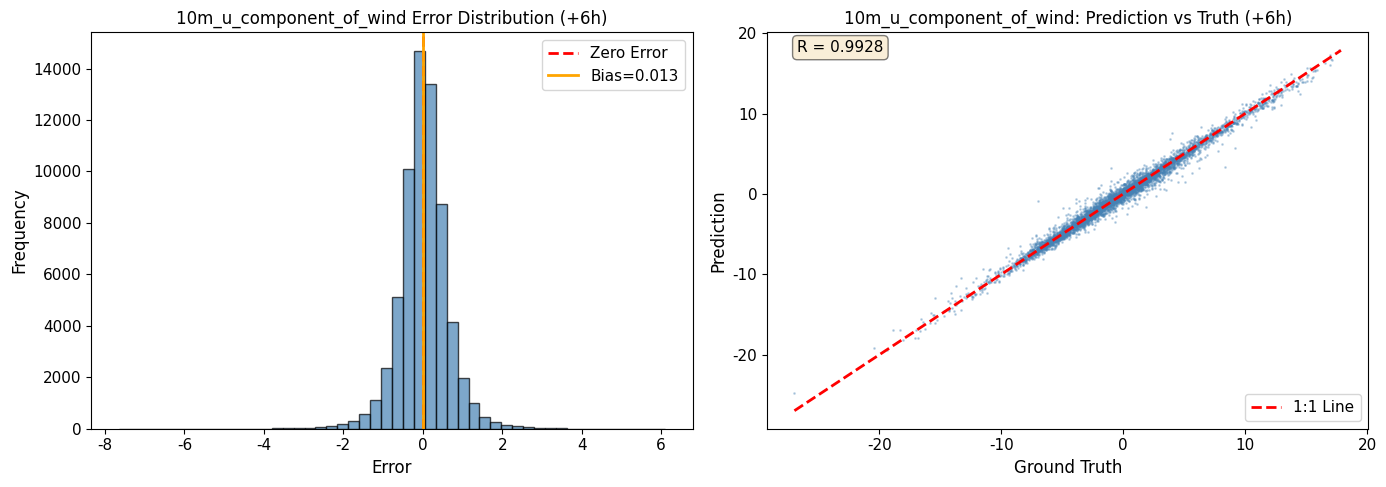


纬度带 RMSE (+6h):
------------------------------
   -82.5N: 0.4938
   -67.5N: 0.6484
   -52.5N: 0.6524
   -37.5N: 0.6979
   -22.5N: 0.6208
    -7.5N: 0.5480
     7.5N: 0.5691
    22.5N: 0.5334
    37.5N: 0.8140
    52.5N: 0.7039
    67.5N: 0.6709
    82.5N: 0.5479
------------------------------
图片已保存: /content/outputs/experiment_10m_u_component_of_wind_latitude.png


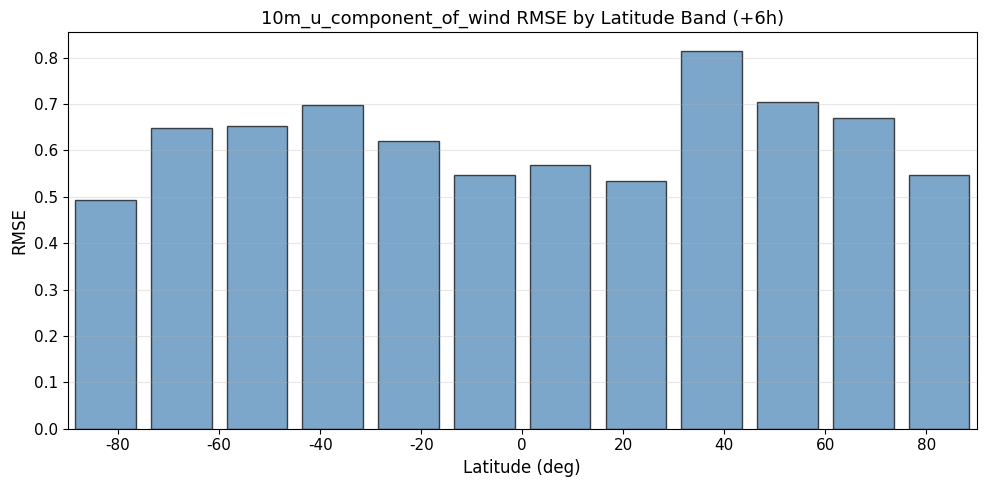

In [ ]:
#@title ## 5.4 自主实验区
#@markdown ### 使用说明
#@markdown
#@markdown 在这里你可以自定义参数进行实验：
#@markdown
#@markdown ---
#@markdown
#@markdown **参数说明**
#@markdown
#@markdown | 参数 | 说明 |
#@markdown |------|------|
#@markdown | `variable` | 要分析的气象变量 |
#@markdown | `show_histogram` | 是否显示误差直方图 |
#@markdown | `compute_spatial_stats` | 是否计算空间统计 |
#@markdown
#@markdown ---
#@markdown **注意**: 只有 +6h 有 Ground Truth 可对比误差
#@markdown
#@markdown ---

#@markdown ### 实验参数

variable = "10m_u_component_of_wind" #@param ["2m_temperature", "mean_sea_level_pressure", "10m_u_component_of_wind", "10m_v_component_of_wind"]
show_histogram = True #@param {type:"boolean"}
compute_spatial_stats = True #@param {type:"boolean"}

print("=" * 50)
print(" 自主实验")
print("=" * 50)
print(f"\n实验配置:")
print(f"  变量: {variable}")
print(f"  分析时间: +6h (唯一有 Ground Truth 的时间步)")

# 获取 ground truth
true_data_all = example_batch.isel(time=-1, batch=0)

# 提取数据
if variable in predictions_multi.data_vars and variable in true_data_all.data_vars:
    pred_data = predictions_multi[variable].isel(time=0)  # +6h
    if 'batch' in pred_data.dims:
        pred_data = pred_data.isel(batch=0)

    true_data = true_data_all[variable]

    # 计算误差
    error = pred_data.values - true_data.values

    # 基本统计
    rmse = float(np.sqrt(np.nanmean(error**2)))
    mae = float(np.nanmean(np.abs(error)))
    bias = float(np.nanmean(error))
    std = float(np.nanstd(error))

    print(f"\n误差统计 (+6h):")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  Bias: {bias:.4f}")
    print(f"  Std:  {std:.4f}")

    if show_histogram:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # 误差直方图
        error_flat = error.flatten()
        error_flat = error_flat[~np.isnan(error_flat)]  # 移除 NaN

        axes[0].hist(error_flat, bins=50, color='steelblue',
                     alpha=0.7, edgecolor='black')
        axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
        axes[0].axvline(x=bias, color='orange', linestyle='-', linewidth=2, label=f'Bias={bias:.3f}')
        axes[0].set_xlabel('Error', fontsize=12)
        axes[0].set_ylabel('Frequency', fontsize=12)
        axes[0].set_title(f'{variable} Error Distribution (+6h)', fontsize=12)
        axes[0].legend()

        # 散点图：预测 vs 真实
        n_samples = min(5000, pred_data.size)
        idx = np.random.choice(pred_data.size, n_samples, replace=False)
        pred_flat = pred_data.values.flatten()[idx]
        true_flat = true_data.values.flatten()[idx]

        # 移除 NaN
        valid = ~(np.isnan(pred_flat) | np.isnan(true_flat))
        pred_flat = pred_flat[valid]
        true_flat = true_flat[valid]

        axes[1].scatter(true_flat, pred_flat, alpha=0.3, s=1, c='steelblue')

        # 添加 1:1 线
        min_val = min(true_flat.min(), pred_flat.min())
        max_val = max(true_flat.max(), pred_flat.max())
        axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 Line')

        axes[1].set_xlabel('Ground Truth', fontsize=12)
        axes[1].set_ylabel('Prediction', fontsize=12)
        axes[1].set_title(f'{variable}: Prediction vs Truth (+6h)', fontsize=12)
        axes[1].legend()

        # 计算相关系数
        corr = np.corrcoef(true_flat, pred_flat)[0, 1]
        axes[1].annotate(f'R = {corr:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                         fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()

        # 保存图片
        save_path = f"{OUTPUT_DIR}/experiment_{variable}.png"
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n图片已保存: {save_path}")

        plt.show()

    if compute_spatial_stats:
        # 计算纬度带平均误差
        lat_values = pred_data.lat.values
        lat_bins = np.arange(-90, 91, 15)
        lat_rmse = []
        lat_centers = []

        print(f"\n纬度带 RMSE (+6h):")
        print("-" * 30)

        for i in range(len(lat_bins) - 1):
            lat_min_bin, lat_max_bin = lat_bins[i], lat_bins[i+1]

            # 找到该纬度带的索引
            lat_mask = (lat_values >= lat_min_bin) & (lat_values < lat_max_bin)

            if np.any(lat_mask):
                error_band = error[lat_mask, :]
                if error_band.size > 0:
                    rmse_band = float(np.sqrt(np.nanmean(error_band**2)))
                    lat_rmse.append(rmse_band)
                    lat_center = (lat_min_bin + lat_max_bin) / 2
                    lat_centers.append(lat_center)
                    print(f"  {lat_center:>6.1f}N: {rmse_band:.4f}")

        print("-" * 30)

        # 绘制纬度带误差图
        if lat_centers:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.bar(lat_centers, lat_rmse, width=12, color='steelblue',
                   alpha=0.7, edgecolor='black')
            ax.set_xlabel('Latitude (deg)', fontsize=12)
            ax.set_ylabel('RMSE', fontsize=12)
            ax.set_title(f'{variable} RMSE by Latitude Band (+6h)', fontsize=13)
            ax.set_xlim(-90, 90)
            ax.grid(True, alpha=0.3, axis='y')

            plt.tight_layout()

            save_path = f"{OUTPUT_DIR}/experiment_{variable}_latitude.png"
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"图片已保存: {save_path}")

            plt.show()

else:
    print(f"\n[!] 变量 {variable} 不在预测结果或原始数据中")
    print(f"    预测变量: {list(predictions_multi.data_vars)}")
    print(f"    原始数据变量: {list(true_data_all.data_vars)}")

---
<a id='第六部分'></a>
# 第六部分: 总结与拓展

## 6.1 GraphCast 的优势

| 方面 | 描述 |
|------|------|
| **速度** | 10天预测 < 1分钟（传统方法需要数小时）|
| **精度** | 在90%以上指标上超越 ECMWF HRES |
| **效率** | 单张 TPU 即可运行，无需超级计算机 |
| **应用** | 极端天气预警、气旋追踪、热浪预测 |

## 6.2 GraphCast 的局限性

| 方面 | 描述 |
|------|------|
| **降水预测** | 降水预测精度相对较低 |
| **极端事件** | 罕见极端事件预测能力有待验证 |
| **可解释性** | 作为黑箱模型，物理可解释性不如 NWP |
| **数据依赖** | 需要高质量历史数据进行训练 |

## 6.3 未来发展方向

1. **GenCast**：概率预测，提供预测不确定性估计
2. **NeuralGCM**：结合物理约束的混合模型
3. **区域高分辨率模型**：针对特定区域的精细化预测
4. **气候变化模拟**：从天气预报扩展到气候预测

In [ ]:
#@title ## 6.4 下载所有结果
#@markdown 将所有生成的图片打包下载

import zipfile
from google.colab import files

print(" 正在打包结果...")
print("-" * 50)

# 创建 zip 文件
zip_filename = '/content/GraphCast_Results.zip'

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files_list in os.walk(OUTPUT_DIR):
        for file in files_list:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, OUTPUT_DIR)
            zipf.write(file_path, arcname)
            print(f"   ✓ {file}")

# 获取文件大小
zip_size = os.path.getsize(zip_filename) / (1024 * 1024)

print(f"\n 打包完成！")
print(f"   文件: {zip_filename}")
print(f"   大小: {zip_size:.2f} MB")
print("\n 正在下载...")

# 下载
files.download(zip_filename)

 正在打包结果...
--------------------------------------------------
   ✓ prediction_comparison_global.png
   ✓ experiment_mean_sea_level_pressure_latitude.png
   ✓ china_wind_field.png
   ✓ city_forecast_Guangzhou.png
   ✓ china_temperature_东北地区.png
   ✓ city_forecast_Haerbin.png
   ✓ experiment_10m_u_component_of_wind.png
   ✓ city_forecast_Wulumuqi.png
   ✓ experiment_2m_temperature_latitude.png
   ✓ experiment_mean_sea_level_pressure.png
   ✓ temperature_forecast_animation.gif
   ✓ global_temperature.png
   ✓ experiment_10m_u_component_of_wind_latitude.png
   ✓ prediction_comparison_china.png
   ✓ china_temperature_华北地区.png
   ✓ graphcast_architecture.png
   ✓ china_temperature_长三角.png
   ✓ experiment_2m_temperature.png
   ✓ error_vs_leadtime.png
   ✓ rmse_by_variable.png
   ✓ vertical_temp_profile.png
   ✓ graphcast_mesh_structure.png
   ✓ rmse_by_region.png
   ✓ prediction_evolution.png
   ✓ china_temperature_全中国.png
   ✓ prediction_analysis.png
   ✓ rmse_by_pressure_level.png
   ✓ city

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title #  附录

#@markdown ---
#@markdown ## A. 关于本实验的数据说明
#@markdown
#@markdown 本实验使用的是 **GraphCast 官方提供的样例数据**：
#@markdown
#@markdown | 属性 | 值 |
#@markdown |------|-----|
#@markdown | 文件名 | `source-era5_date-2022-01-01_res-1.0_levels-13_steps-01.nc` |
#@markdown | 分辨率 | 1.0° (约 100km) |
#@markdown | 气压层 | 13 层 |
#@markdown | 时间步 | **1 步** (只有 +6h 的 Ground Truth) |
#@markdown | 日期 | 2022-01-01 |
#@markdown
#@markdown 由于样例数据只有 1 个预测时间步的验证数据，本实验中的误差分析仅限于 **+6h** 预测。
#@markdown 如果你想验证更长时间的预测（如 +24h, +48h, 甚至 10 天），需要获取更多时间步的数据。
#@markdown
#@markdown ---
#@markdown ## B. 如何获取更多数据
#@markdown
#@markdown ### 方法 1：ARCO-ERA5 (推荐)
#@markdown
#@markdown Google Cloud 提供了完整的 ERA5 再分析数据，可以直接用 Python 读取：
#@markdown
#@markdown ```python
#@markdown import xarray as xr
#@markdown
#@markdown ds = xr.open_zarr(
#@markdown     'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
#@markdown     chunks=None,
#@markdown     storage_options=dict(token='anon')
#@markdown )
#@markdown data = ds.sel(time=slice('2022-01-01', '2022-01-03'))
#@markdown ```
#@markdown
#@markdown ### 方法 2：WeatherBench2
#@markdown
#@markdown WeatherBench2 提供了专门为天气预测模型准备的数据集：https://github.com/google-research/weatherbench2
#@markdown
#@markdown ### 方法 3：ECMWF Climate Data Store
#@markdown
#@markdown 从 ECMWF 官方下载原始 ERA5 数据（需要注册账号）：https://cds.climate.copernicus.eu
#@markdown
#@markdown ---
#@markdown ## C. 模型文件说明
#@markdown
#@markdown GraphCast 提供了三个预训练模型：
#@markdown
#@markdown | 模型 | 分辨率 | 气压层 | 说明 |
#@markdown |------|--------|--------|------|
#@markdown | `GraphCast` | 0.25° | 37 层 | 完整版，需要大量显存 |
#@markdown | `GraphCast_small` | 1.0° | 13 层 | 轻量版，适合学习和实验 ✓ |
#@markdown | `GraphCast_operational` | 0.25° | 13 层 | 业务版，可用 HRES 数据初始化 |
#@markdown
#@markdown 本实验使用 **GraphCast_small**，适合在 Colab 免费 GPU 上运行。
#@markdown
#@markdown ---
#@markdown ## D. 常见问题
#@markdown
#@markdown **Q1: 为什么误差分析只有 +6h？**
#@markdown
#@markdown A: 样例数据 (`steps-01`) 只包含 3 个时间步：t-1, t, t+1。其中 t+1 (+6h) 是唯一的 Ground Truth。
#@markdown 要验证更长预测，需要下载包含更多时间步的数据。
#@markdown
#@markdown **Q2: GPU 内存不足怎么办？**
#@markdown - 使用 `GraphCast_small` 模型
#@markdown - 减少预测步数
#@markdown - 使用 `jax.clear_caches()` 清理缓存
#@markdown
#@markdown **Q3: 模型下载失败？**
#@markdown - 检查网络连接
#@markdown - 尝试重新运行下载单元格
#@markdown - 使用 VPN 或代理
#@markdown
#@markdown **Q4: 预测结果不合理？**
#@markdown - 检查输入数据的时间步是否正确
#@markdown - 确保使用了正确的归一化统计量
#@markdown - 验证模型版本与数据分辨率匹配
#@markdown
#@markdown **Q5: 如何使用高分辨率模型？**
#@markdown
#@markdown A: 需要下载 0.25° 分辨率的数据和对应的模型权重，并确保有足够的 GPU 显存（建议 32GB+）。
#@markdown
#@markdown ---
#@markdown ## E. 进一步探索建议
#@markdown
#@markdown ### 实验拓展
#@markdown - 下载更多时间步的数据，验证 GraphCast 在 1-10 天预测的误差累积
#@markdown - 对比不同季节（夏季 vs 冬季）的预测精度
#@markdown - 分析极端天气事件（台风、寒潮）的预测能力
#@markdown - 使用高分辨率模型 `GraphCast_operational`
#@markdown
#@markdown ### 相关论文
#@markdown - **GraphCast (2023)**: Learning skillful medium-range global weather forecasting
#@markdown - **GenCast (2024)**: Diffusion-based ensemble forecasting for medium-range weather
#@markdown - **Pangu-Weather (2023)**: 华为的 AI 天气预测模型
#@markdown - **FourCastNet (2022)**: NVIDIA 的傅里叶神经算子天气模型
#@markdown
#@markdown ---
#@markdown ## F. 参考资料
#@markdown
#@markdown | 资源 | 链接 |
#@markdown |------|------|
#@markdown | GraphCast 论文 (Science) | https://www.science.org/doi/10.1126/science.adi2336 |
#@markdown | GraphCast GitHub | https://github.com/google-deepmind/graphcast |
#@markdown | Google DeepMind 博客 | https://deepmind.google/discover/blog/graphcast-ai-model-for-faster-and-more-accurate-global-weather-forecasting/ |
#@markdown | 官方 Colab Demo | https://colab.research.google.com/github/google-deepmind/graphcast/blob/main/graphcast_demo.ipynb |
#@markdown | Google Cloud Bucket | https://console.cloud.google.com/storage/browser/dm_graphcast |
#@markdown | ARCO-ERA5 数据 | https://github.com/google-research/arco-era5 |
#@markdown | WeatherBench2 | https://github.com/google-research/weatherbench2 |
#@markdown | ECMWF ERA5 数据集 | https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5 |
#@markdown
#@markdown ---
#@markdown ## G. 术语表
#@markdown
#@markdown | 术语 | 解释 |
#@markdown |------|------|
#@markdown | ERA5 | ECMWF 第五代再分析数据集 |
#@markdown | GNN | 图神经网络 (Graph Neural Network) |
#@markdown | RMSE | 均方根误差 (Root Mean Square Error) |
#@markdown | MAE | 平均绝对误差 (Mean Absolute Error) |
#@markdown | NWP | 数值天气预报 (Numerical Weather Prediction) |
#@markdown | HRES | 高分辨率预报 (High Resolution Forecast) |
#@markdown | Autoregressive | 自回归，将预测结果作为下一步输入 |
#@markdown | Lead Time | 预报时效，从预测发布到预测目标时间的间隔 |
#@markdown | Encoder | 编码器，将网格数据映射到图结构 |
#@markdown | Decoder | 解码器，将图特征映射回网格 |
#@markdown | Processor | 处理器，在图上进行消息传递的 GNN |
#@markdown | Residual Learning | 残差学习，预测变化量而非绝对值 |

print("=" * 60)
print(" 附录")
print("=" * 60)
print("""
A. 关于本实验的数据说明
   - 样例数据只有 1 个预测时间步 (+6h) 的 Ground Truth
   - 误差分析仅限于 +6h 预测

B. 如何获取更多数据
   - ARCO-ERA5 (推荐)
   - WeatherBench2
   - ECMWF Climate Data Store

C. 模型文件说明
   - GraphCast: 0.25°, 37层 (完整版)
   - GraphCast_small: 1.0°, 13层 (本实验使用)
   - GraphCast_operational: 0.25°, 13层 (业务版)

D. 常见问题 (FAQ)

E. 进一步探索建议

F. 参考资料与官方链接

G. 术语表
""")
print("=" * 60)
print("\n详细内容请查看上方的 Markdown 说明。")
print("\n官方资源:")
print("  GitHub:  https://github.com/google-deepmind/graphcast")
print("  论文:    https://www.science.org/doi/10.1126/science.adi2336")
print("  数据:    gs://dm_graphcast/dataset/")

---

##  恭喜完成本课程！

你已经学习了：
- 天气数据的基本结构与可视化
- 图神经网络在气象预测中的应用
- GraphCast 模型的运行与预测
- 预测结果的分析与评估
- 参数实验与对比分析

---

**参考文献**

Lam, R., Sanchez-Gonzalez, A., Willson, M., Wirnsberger, P., Fortunato, M., Alet, F., ... & Battaglia, P. (2023). Learning skillful medium-range global weather forecasting. *Science*, 382(6677), 1416-1421.

---

*本教学 Notebook 基于 Google DeepMind 的 GraphCast 项目开发，仅供教学使用。*